In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [ ]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.9,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-justDice"
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]

In [3]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [4]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
f_alpha = (1-b)/(1-np.power(b,train_class_counts))
print(f_alpha)

[0.00143064 0.00320357 0.00319653 0.00323937 0.0038239  0.00244738
 0.00244738 0.003468   0.00375    0.00556448 0.01478441 0.04809698
 1.         0.00365007 0.01689033 0.00825881 0.00380244 0.00985004
 0.02090204 0.0268058  0.00482751 0.02374777 0.02132692 0.03274452
 0.01637033 0.00838066]


In [5]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [6]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [7]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [9]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0)
total loss : -0.0491490011010319 - dice loss : -0.0491490011010319 - 
train avg metrics for epoch 0 :
avg dice : 0.016457257821821454 - avg precision : 0.010455209514584568 - avg recall : 0.09751814741384805
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : -0.08779058698564768 - dice loss : -0.08779058698564768 - 
valid avg metrics for epoch 0 :
avg dice : 0.04250920815920696 - avg precision : 0.03556275896116858 - avg recall : 0.12328411775168206
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 16613.330078
encoders.0.layers.0.layers.0.bias: 0.114371
encoders.0.layers.0.layers.1.weight: 290.001556
encoders.0.layers.0.layers.1.bias: 187.311569
encoders.0.layers.1.layers.0.weight: 5337.525879
encoders.0.layers.1.layers.0.bias: 0.026922
encoders.0.layers.1.layers.1.weight: 314.431091
encoders.0.layers.1.layers.1.bias: 232.671982
encoders.1.layers.0.layers.0.weight: 3989.810547
encoders.1.layers.0.layers.0.bias: 0.018481
encoders.1.layers.0.layers.1.weight: 236.456848
encoders.1.layers.0.layers.1.bias: 177.093460
encoders.1.layers.1.layers.0.weight: 2917.592773
encoders.1.layers.1.layers.0.bias: 0.009304
encoders.1.layers.1.layers.1.weight: 268.573181
encoders.1.layers.1.layers.1.bias: 154.389709
encoders.2.layers.0.layers.0.weight: 2290.807129
encoders.2.layers.0.layers.0.bias: 0.004846
encoders.2.layers.0.layers.1.weight: 159.352753
encoders.2.layers.0.layers.1.bias: 97.794044
encoders.2.layers.1.layers.0.weight: 2244

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2)
total loss : -0.24617335915565491 - dice loss : -0.24617335915565491 - 
train avg metrics for epoch 2 :
avg dice : 0.11242212745719166 - avg precision : 0.09146788218524307 - avg recall : 0.18517374760238453
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : -0.2653449773788452 - dice loss : -0.2653449773788452 - 
valid avg metrics for epoch 2 :
avg dice : 0.13684187871724085 - avg precision : 0.11950914212124189 - avg recall : 0.20313726655789652
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3)
total loss : -0.32133340656757353 - dice loss : -0.32133340656757353 - 
train avg metrics for epoch 3 :
avg dice : 0.14396163148871768 - avg precision : 0.12265592513111187 - avg recall : 0.21612481656717136
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : -0.3051679447293282 - dice loss : -0.3051679447293282 - 
valid avg metrics for epoch 3 :
avg dice : 0.15130054671243798 - avg precision : 0.12856601201521697 - avg recall : 0.22358689229135054
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : -0.35404166370630263 - dice loss : -0.35404166370630263 - 
train avg metrics for epoch 4 :
avg dice : 0.15789024147287473 - avg precision : 0.13541356160436407 - avg recall : 0.22714918411067628
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : -0.32459563836455346 - dice loss : -0.32459563836455346 - 
valid avg metrics for epoch 4 :
avg dice : 0.16718363161810226 - avg precision : 0.15576758129522206 - avg recall : 0.21740916520357131
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : -0.38197839200496675 - dice loss : -0.38197839200496675 - 
train avg metrics for epoch 5 :
avg dice : 0.17489987038377425 - avg precision : 0.15091261361551006 - avg recall : 0.24203668820533494
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : -0.3353161960840225 - dice loss : -0.3353161960840225 - 
valid avg metrics for epoch 5 :
avg dice : 0.17487912688489676 - avg precision : 0.16107594262663041 - avg recall : 0.22500230347097386
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : -0.3882980328798294 - dice loss : -0.3882980328798294 - 
train avg metrics for epoch 6 :
avg dice : 0.17964456571480045 - avg precision : 0.15256982563107158 - avg recall : 0.24607107167685172
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : -0.36806137263774874 - dice loss : -0.36806137263774874 - 
valid avg metrics for epoch 6 :
avg dice : 0.1916382187188851 - avg precision : 0.17027884886658284 - avg recall : 0.2450969173584599
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 3336.710449
encoders.0.layers.0.layers.0.bias: 0.247471
encoders.0.layers.0.layers.1.weight: 60.073853
encoders.0.layers.0.layers.1.bias: 87.539856
encoders.0.layers.1.layers.0.weight: 769.909302
encoders.0.layers.1.layers.0.bias: 0.009389
encoders.0.layers.1.layers.1.weight: 100.099327
encoders.0.layers.1.layers.1.bias: 75.874084
encoders.1.layers.0.layers.0.weight: 795.590759
encoders.1.layers.0.layers.0.bias: 0.006328
encoders.1.layers.0.layers.1.weight: 85.438911
encoders.1.layers.0.layers.1.bias: 70.908333
encoders.1.layers.1.layers.0.weight: 751.254395
encoders.1.layers.1.layers.0.bias: 0.004436
encoders.1.layers.1.layers.1.weight: 111.354767
encoders.1.layers.1.layers.1.bias: 60.583054
encoders.2.layers.0.layers.0.weight: 498.744873
encoders.2.layers.0.layers.0.bias: 0.001805
encoders.2.layers.0.layers.1.weight: 72.887039
encoders.2.layers.0.layers.1.bias: 41.456810
encoders.2.layers.1.layers.0.weight: 409.168304
encod

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8)
total loss : -0.42535382628440854 - dice loss : -0.42535382628440854 - 
train avg metrics for epoch 8 :
avg dice : 0.2051034361436524 - avg precision : 0.17929803896404337 - avg recall : 0.2683995320262329
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8)
total loss : -0.3754343748092651 - dice loss : -0.3754343748092651 - 
valid avg metrics for epoch 8 :
avg dice : 0.20426886521004292 - avg precision : 0.19256850672594739 - avg recall : 0.24904515948146583
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : -0.43194388046860693 - dice loss : -0.43194388046860693 - 
train avg metrics for epoch 9 :
avg dice : 0.20854130640520283 - avg precision : 0.18079074003879214 - avg recall : 0.2745825512241572
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : -0.38717158138751984 - dice loss : -0.38717158138751984 - 
valid avg metrics for epoch 9 :
avg dice : 0.21048801509562565 - avg precision : 0.18831578005338087 - avg recall : 0.2693824407272041
1 => dice : 0.5995388031005859 p : 0.5877262353897095 , r : 0.6118358969688416
2 => dice : 0.5814335942268372 p : 0.54810631275177 , r : 0.619076132774353
3 => dice : 0.5729029774665833 p : 0.5539552569389343 , r : 0.5931927561759949
4 => dice : 0.34434255957603455 p : 0.358271986246109 , r : 0.3314557373523712
5 => dice : 0.5469623804092407 p : 0.5223059058189392 , r : 0.5740621089935303
6 => dice : 0.47381147742271423 p : 0.3826662302017212 , r : 0.621950626373291
7 => dice : 0.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10)
total loss : -0.4251061576604843 - dice loss : -0.4251061576604843 - 
train avg metrics for epoch 10 :
avg dice : 0.2026096867736106 - avg precision : 0.17417713970804471 - avg recall : 0.2703446599282324
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : -0.39564278572797773 - dice loss : -0.39564278572797773 - 
valid avg metrics for epoch 10 :
avg dice : 0.21873453804947587 - avg precision : 0.20623864354696708 - avg recall : 0.2665045326668769
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : -0.4483508688211441 - dice loss : -0.4483508688211441 - 
train avg metrics for epoch 11 :
avg dice : 0.2196967073877368 - avg precision : 0.19034954310540342 - avg recall : 0.2920111775398254
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : -0.40557159185409547 - dice loss : -0.40557159185409547 - 
valid avg metrics for epoch 11 :
avg dice : 0.22599758417302876 - avg precision : 0.21163930168404477 - avg recall : 0.27798768889158965
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12)
total loss : -0.44560465335845945 - dice loss : -0.44560465335845945 - 
train avg metrics for epoch 12 :
avg dice : 0.2194305895299087 - avg precision : 0.19074731997578057 - avg recall : 0.2918634879589081
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : -0.39204747080802915 - dice loss : -0.39204747080802915 - 
valid avg metrics for epoch 12 :
avg dice : 0.2156884844253446 - avg precision : 0.19769469344901153 - avg recall : 0.26873083859682084
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13)
total loss : -0.44330681413412093 - dice loss : -0.44330681413412093 - 
train avg metrics for epoch 13 :
avg dice : 0.21639099270959014 - avg precision : 0.18689511486460106 - avg recall : 0.2910879249195568
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : -0.41185661852359773 - dice loss : -0.41185661852359773 - 
valid avg metrics for epoch 13 :
avg dice : 0.22400462247504715 - avg precision : 0.20210464860138017 - avg recall : 0.2840642900764942
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14)
total loss : -0.47417854428291323 - dice loss : -0.47417854428291323 - 
train avg metrics for epoch 14 :
avg dice : 0.23603148130884294 - avg precision : 0.20626800343758078 - avg recall : 0.3121883660973981
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : -0.4139604538679123 - dice loss : -0.4139604538679123 - 
valid avg metrics for epoch 14 :
avg dice : 0.2273933423148807 - avg precision : 0.20720561669179005 - avg recall : 0.28579443469643595
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15)
total loss : -0.4683681362867355 - dice loss : -0.4683681362867355 - 
train avg metrics for epoch 15 :
avg dice : 0.23318531025647285 - avg precision : 0.2042633335881692 - avg recall : 0.307990340590477
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15)
total loss : -0.41084481328725814 - dice loss : -0.41084481328725814 - 
valid avg metrics for epoch 15 :
avg dice : 0.22590752808273432 - avg precision : 0.2130202012564405 - avg recall : 0.28572157701011747
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16)
total loss : -0.4814925041794777 - dice loss : -0.4814925041794777 - 
train avg metrics for epoch 16 :
avg dice : 0.23842082507161216 - avg precision : 0.20817866208351915 - avg recall : 0.3141737569961697
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : -0.4352157965302467 - dice loss : -0.4352157965302467 - 
valid avg metrics for epoch 16 :
avg dice : 0.24665982566670178 - avg precision : 0.22548076846229378 - avg recall : 0.30618006564676764
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : -0.49614454567432403 - dice loss : -0.49614454567432403 - 
train avg metrics for epoch 17 :
avg dice : 0.2501658199780887 - avg precision : 0.2197147217935708 - avg recall : 0.32922226706519725
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : -0.43630203157663344 - dice loss : -0.43630203157663344 - 
valid avg metrics for epoch 17 :
avg dice : 0.24962398598157928 - avg precision : 0.233183935135894 - avg recall : 0.3081973857432604
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : -0.48198469847440717 - dice loss : -0.48198469847440717 - 
train avg metrics for epoch 18 :
avg dice : 0.24214519636889786 - avg precision : 0.21212471314967843 - avg recall : 0.32124951750040054
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : -0.4316500395536423 - dice loss : -0.4316500395536423 - 
valid avg metrics for epoch 18 :
avg dice : 0.24539726415428928 - avg precision : 0.23560287667118246 - avg recall : 0.30309688225388526
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19)
total loss : -0.500666381418705 - dice loss : -0.500666381418705 - 
train avg metrics for epoch 19 :
avg dice : 0.253179243144501 - avg precision : 0.22324159761250484 - avg recall : 0.33266387820243837
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : -0.43358644992113116 - dice loss : -0.43358644992113116 - 
valid avg metrics for epoch 19 :
avg dice : 0.24878450059693902 - avg precision : 0.23432842355745379 - avg recall : 0.3098154403269291
1 => dice : 0.6355423331260681 p : 0.6264016032218933 , r : 0.644953727722168
2 => dice : 0.6356608867645264 p : 0.5877711772918701 , r : 0.692046582698822
3 => dice : 0.6216781139373779 p : 0.6062544584274292 , r : 0.6379070281982422
4 => dice : 0.37961193919181824 p : 0.32502543926239014 , r : 0.4562343657016754
5 => dice : 0.646353542804718 p : 0.7128304839134216 , r : 0.5912179350852966
6 => dice : 0.49392086267471313 p : 0.44312313199043274 , r : 0.557873010635376
7 => dice : 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20)
total loss : -0.5085906666517258 - dice loss : -0.5085906666517258 - 
train avg metrics for epoch 20 :
avg dice : 0.25901408925021857 - avg precision : 0.22905107240760117 - avg recall : 0.3414682035893202
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : -0.4473577097058296 - dice loss : -0.4473577097058296 - 
valid avg metrics for epoch 20 :
avg dice : 0.2581679146423807 - avg precision : 0.24192822746204912 - avg recall : 0.3182266668975353
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : -0.5125842532515525 - dice loss : -0.5125842532515525 - 
train avg metrics for epoch 21 :
avg dice : 0.26212287936629547 - avg precision : 0.23260838901172975 - avg recall : 0.3440710550136282
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : -0.453876319527626 - dice loss : -0.453876319527626 - 
valid avg metrics for epoch 21 :
avg dice : 0.25928986833674217 - avg precision : 0.24145564941631165 - avg recall : 0.31778371898806657
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22)
total loss : -0.5242427280545234 - dice loss : -0.5242427280545234 - 
train avg metrics for epoch 22 :
avg dice : 0.2684356684771112 - avg precision : 0.23746061278812702 - avg recall : 0.35080577187240125
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : -0.46185789108276365 - dice loss : -0.46185789108276365 - 
valid avg metrics for epoch 22 :
avg dice : 0.2648916611181231 - avg precision : 0.24656616204680176 - avg recall : 0.32892565546557306
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 10580.344727
encoders.0.layers.0.layers.0.bias: 0.168369
encoders.0.layers.0.layers.1.weight: 212.647125
encoders.0.layers.0.layers.1.bias: 159.961731
encoders.0.layers.1.layers.0.weight: 1174.241577
encoders.0.layers.1.layers.0.bias: 0.013580
encoders.0.layers.1.layers.1.weight: 221.424805
encoders.0.layers.1.layers.1.bias: 284.077240
encoders.1.layers.0.layers.0.weight: 1195.356934
encoders.1.layers.0.layers.0.bias: 0.012622
encoders.1.layers.0.layers.1.weight: 157.719193
encoders.1.layers.0.layers.1.bias: 151.927368
encoders.1.layers.1.layers.0.weight: 990.505554
encoders.1.layers.1.layers.0.bias: 0.010599
encoders.1.layers.1.layers.1.weight: 171.165588
encoders.1.layers.1.layers.1.bias: 125.145737
encoders.2.layers.0.layers.0.weight: 680.914734
encoders.2.layers.0.layers.0.bias: 0.003701
encoders.2.layers.0.layers.1.weight: 116.230171
encoders.2.layers.0.layers.1.bias: 103.718437
encoders.2.layers.1.layers.0.weight: 481.8

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : -0.5170198124647141 - dice loss : -0.5170198124647141 - 
train avg metrics for epoch 24 :
avg dice : 0.2638650142117036 - avg precision : 0.23419742750702427 - avg recall : 0.3462430342845619
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : -0.4662500575184822 - dice loss : -0.4662500575184822 - 
valid avg metrics for epoch 24 :
avg dice : 0.27240630542928207 - avg precision : 0.25756026696268236 - avg recall : 0.3353935171291232
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25)
total loss : -0.5319787272810936 - dice loss : -0.5319787272810936 - 
train avg metrics for epoch 25 :
avg dice : 0.2751156040811544 - avg precision : 0.24415767966740531 - avg recall : 0.36193623308092354
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : -0.4586716562509537 - dice loss : -0.4586716562509537 - 
valid avg metrics for epoch 25 :
avg dice : 0.26637951715801694 - avg precision : 0.24970382586150663 - avg recall : 0.32554671455174683
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26)
total loss : -0.5361151078343391 - dice loss : -0.5361151078343391 - 
train avg metrics for epoch 26 :
avg dice : 0.277272450602402 - avg precision : 0.24622385552414927 - avg recall : 0.36169879520311954
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : -0.46470649242401124 - dice loss : -0.46470649242401124 - 
valid avg metrics for epoch 26 :
avg dice : 0.2663000974589851 - avg precision : 0.24834308748220793 - avg recall : 0.32794707011431457
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : -0.5438807925581932 - dice loss : -0.5438807925581932 - 
train avg metrics for epoch 27 :
avg dice : 0.2821465558533306 - avg precision : 0.2508456850677612 - avg recall : 0.36678884107619525
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : -0.4787858217954636 - dice loss : -0.4787858217954636 - 
valid avg metrics for epoch 27 :
avg dice : 0.27759086277812106 - avg precision : 0.25708219966472823 - avg recall : 0.3440714115742594
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28)
total loss : -0.5494628518819809 - dice loss : -0.5494628518819809 - 
train avg metrics for epoch 28 :
avg dice : 0.28662251845417597 - avg precision : 0.2557831592937873 - avg recall : 0.37213955491781237
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : -0.4726384997367859 - dice loss : -0.4726384997367859 - 
valid avg metrics for epoch 28 :
avg dice : 0.2800874958514361 - avg precision : 0.26702255190350116 - avg recall : 0.3440687584504485
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29)
total loss : -0.5416129264235496 - dice loss : -0.5416129264235496 - 
train avg metrics for epoch 29 :
avg dice : 0.2823201861896873 - avg precision : 0.2505661205072829 - avg recall : 0.3699630048498511
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : -0.4680522337555885 - dice loss : -0.4680522337555885 - 
valid avg metrics for epoch 29 :
avg dice : 0.2733658821439495 - avg precision : 0.260513237460691 - avg recall : 0.33343336708843707
1 => dice : 0.6758264899253845 p : 0.6399549245834351 , r : 0.7159583568572998
2 => dice : 0.6431483030319214 p : 0.6544481515884399 , r : 0.6322320699691772
3 => dice : 0.637042760848999 p : 0.6249520182609558 , r : 0.6496105790138245
4 => dice : 0.4210808575153351 p : 0.3899060785770416 , r : 0.4576739966869354
5 => dice : 0.6754642128944397 p : 0.7222568392753601 , r : 0.6343657374382019
6 => dice : 0.5612202882766724 p : 0.5477938055992126 , r : 0.5753214955329895
7 => dice : 0.44

  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 4610.315430
encoders.0.layers.0.layers.0.bias: 0.226234
encoders.0.layers.0.layers.1.weight: 260.911682
encoders.0.layers.0.layers.1.bias: 247.624344
encoders.0.layers.1.layers.0.weight: 1621.847046
encoders.0.layers.1.layers.0.bias: 0.021963
encoders.0.layers.1.layers.1.weight: 315.030518
encoders.0.layers.1.layers.1.bias: 233.593063
encoders.1.layers.0.layers.0.weight: 1735.994507
encoders.1.layers.0.layers.0.bias: 0.015924
encoders.1.layers.0.layers.1.weight: 268.782806
encoders.1.layers.0.layers.1.bias: 351.204285
encoders.1.layers.1.layers.0.weight: 1442.074585
encoders.1.layers.1.layers.0.bias: 0.011342
encoders.1.layers.1.layers.1.weight: 408.832764
encoders.1.layers.1.layers.1.bias: 232.469864
encoders.2.layers.0.layers.0.weight: 1089.328125
encoders.2.layers.0.layers.0.bias: 0.004860
encoders.2.layers.0.layers.1.weight: 216.059631
encoders.2.layers.0.layers.1.bias: 121.212387
encoders.2.layers.1.layers.0.weight: 861.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (31)
total loss : -0.5545054599642754 - dice loss : -0.5545054599642754 - 
train avg metrics for epoch 31 :
avg dice : 0.2875631869107816 - avg precision : 0.2553679029796331 - avg recall : 0.3757378386706114
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (31)
total loss : -0.4870696410536766 - dice loss : -0.4870696410536766 - 
valid avg metrics for epoch 31 :
avg dice : 0.28589100232998693 - avg precision : 0.2640066551725613 - avg recall : 0.3554260628670454
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (32)
total loss : -0.5669313323497772 - dice loss : -0.5669313323497772 - 
train avg metrics for epoch 32 :
avg dice : 0.2962782933165061 - avg precision : 0.2639276453841012 - avg recall : 0.3853264343738556
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (32)
total loss : -0.48929630815982816 - dice loss : -0.48929630815982816 - 
valid avg metrics for epoch 32 :
avg dice : 0.28627468232774494 - avg precision : 0.2601124495465774 - avg recall : 0.3582208858430386
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (33)
total loss : -0.5716995176672935 - dice loss : -0.5716995176672935 - 
train avg metrics for epoch 33 :
avg dice : 0.30053500377085174 - avg precision : 0.26832550187114973 - avg recall : 0.393059691414237
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33)
total loss : -0.49655556082725527 - dice loss : -0.49655556082725527 - 
valid avg metrics for epoch 33 :
avg dice : 0.29785621088590786 - avg precision : 0.2824892270858982 - avg recall : 0.361705072671175
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (34)
total loss : -0.566362801194191 - dice loss : -0.566362801194191 - 
train avg metrics for epoch 34 :
avg dice : 0.29722451124426497 - avg precision : 0.264999532544316 - avg recall : 0.38417816668748855
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34)
total loss : -0.496906216442585 - dice loss : -0.496906216442585 - 
valid avg metrics for epoch 34 :
avg dice : 0.2982400607056795 - avg precision : 0.2803045199791086 - avg recall : 0.36377562768757343
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (35)
total loss : -0.578238924741745 - dice loss : -0.578238924741745 - 
train avg metrics for epoch 35 :
avg dice : 0.30475499000582856 - avg precision : 0.2712068738906237 - avg recall : 0.4009847562760115
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (35)
total loss : -0.4994561716914177 - dice loss : -0.4994561716914177 - 
valid avg metrics for epoch 35 :
avg dice : 0.2961869410717414 - avg precision : 0.2742468684830237 - avg recall : 0.36466635406017306
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (36)
total loss : -0.5808519318699836 - dice loss : -0.5808519318699836 - 
train avg metrics for epoch 36 :
avg dice : 0.3071481854964493 - avg precision : 0.2749564065400045 - avg recall : 0.3995407545566559
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (36)
total loss : -0.5021542981266975 - dice loss : -0.5021542981266975 - 
valid avg metrics for epoch 36 :
avg dice : 0.2961205917481367 - avg precision : 0.2714083495858358 - avg recall : 0.36251412726938725
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (37)
total loss : -0.5836162507534027 - dice loss : -0.5836162507534027 - 
train avg metrics for epoch 37 :
avg dice : 0.30891807708256297 - avg precision : 0.2754202646884369 - avg recall : 0.4040188984572887
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (37)
total loss : -0.48339673429727553 - dice loss : -0.48339673429727553 - 
valid avg metrics for epoch 37 :
avg dice : 0.29166963838107857 - avg precision : 0.2899226817468298 - avg recall : 0.3536134393513203
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (38)
total loss : -0.5732860270142556 - dice loss : -0.5732860270142556 - 
train avg metrics for epoch 38 :
avg dice : 0.30246935939835756 - avg precision : 0.27064730315294583 - avg recall : 0.3945115466415882
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (38)
total loss : -0.5008704513311386 - dice loss : -0.5008704513311386 - 
valid avg metrics for epoch 38 :
avg dice : 0.2981907637424042 - avg precision : 0.2826808643640834 - avg recall : 0.3573089500516653
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (39)
total loss : -0.5882629522681236 - dice loss : -0.5882629522681236 - 
train avg metrics for epoch 39 :
avg dice : 0.31328495961965513 - avg precision : 0.2814559334491787 - avg recall : 0.4081424790620804
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (39)
total loss : -0.4996917098760605 - dice loss : -0.4996917098760605 - 
valid avg metrics for epoch 39 :
avg dice : 0.3014304124413456 - avg precision : 0.279842653303931 - avg recall : 0.3749140338599682
1 => dice : 0.7076168060302734 p : 0.6778728365898132 , r : 0.7400907278060913
2 => dice : 0.6843277812004089 p : 0.6463983654975891 , r : 0.7269858717918396
3 => dice : 0.6686022281646729 p : 0.620793342590332 , r : 0.724389374256134
4 => dice : 0.4573934078216553 p : 0.38820886611938477 , r : 0.5565851330757141
5 => dice : 0.7116978168487549 p : 0.7351369857788086 , r : 0.6897071003913879
6 => dice : 0.6021878123283386 p : 0.5788260102272034 , r : 0.6275147199630737
7 => dice : 0.56

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (40)
total loss : -0.5784926077723503 - dice loss : -0.5784926077723503 - 
train avg metrics for epoch 40 :
avg dice : 0.3090773071544781 - avg precision : 0.27678675298695454 - avg recall : 0.4035408434271812
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (40)
total loss : -0.514615723490715 - dice loss : -0.514615723490715 - 
valid avg metrics for epoch 40 :
avg dice : 0.306612152089441 - avg precision : 0.28112300368404247 - avg recall : 0.37777515426278113
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 15619.942383
encoders.0.layers.0.layers.0.bias: 0.265516
encoders.0.layers.0.layers.1.weight: 644.431091
encoders.0.layers.0.layers.1.bias: 948.757202
encoders.0.layers.1.layers.0.weight: 3331.621582
encoders.0.layers.1.layers.0.bias: 0.015701
encoders.0.layers.1.layers.1.weight: 731.387817
encoders.0.layers.1.layers.1.bias: 818.985107
encoders.1.layers.0.layers.0.weight: 3149.027588
encoders.1.layers.0.layers.0.bias: 0.013888
encoders.1.layers.0.layers.1.weight: 572.761658
encoders.1.layers.0.layers.1.bias: 574.431763
encoders.1.layers.1.layers.0.weight: 2396.529297
encoders.1.layers.1.layers.0.bias: 0.012709
encoders.1.layers.1.layers.1.weight: 701.912842
encoders.1.layers.1.layers.1.bias: 604.366516
encoders.2.layers.0.layers.0.weight: 1895.757202
encoders.2.layers.0.layers.0.bias: 0.006346
encoders.2.layers.0.layers.1.weight: 447.577545
encoders.2.layers.0.layers.1.bias: 368.296661
encoders.2.layers.1.layers.0.weight: 124

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (42)
total loss : -0.5902593809366227 - dice loss : -0.5902593809366227 - 
train avg metrics for epoch 42 :
avg dice : 0.31653512859692073 - avg precision : 0.2846539582918922 - avg recall : 0.41232170164585114
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (42)
total loss : -0.5141900062561036 - dice loss : -0.5141900062561036 - 
valid avg metrics for epoch 42 :
avg dice : 0.30909375278110324 - avg precision : 0.29123963530902985 - avg recall : 0.3821850910782814
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (43)
total loss : -0.5875183936953544 - dice loss : -0.5875183936953544 - 
train avg metrics for epoch 43 :
avg dice : 0.313171145101396 - avg precision : 0.2812640269609983 - avg recall : 0.4065405507385731
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (43)
total loss : -0.5050473108887672 - dice loss : -0.5050473108887672 - 
valid avg metrics for epoch 43 :
avg dice : 0.30513289742643507 - avg precision : 0.28452403575152857 - avg recall : 0.3767621524631977
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (44)
total loss : -0.6074306160211563 - dice loss : -0.6074306160211563 - 
train avg metrics for epoch 44 :
avg dice : 0.3266652324458282 - avg precision : 0.2945630488761526 - avg recall : 0.42324056178331376
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (44)
total loss : -0.5154666393995285 - dice loss : -0.5154666393995285 - 
valid avg metrics for epoch 44 :
avg dice : 0.3038919665245851 - avg precision : 0.2777732761684456 - avg recall : 0.37605452999472616
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (45)
total loss : -0.5908187884092331 - dice loss : -0.5908187884092331 - 
train avg metrics for epoch 45 :
avg dice : 0.31533905366902365 - avg precision : 0.2810553414314927 - avg recall : 0.41075276434421537
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (45)
total loss : -0.4939676061272621 - dice loss : -0.4939676061272621 - 
valid avg metrics for epoch 45 :
avg dice : 0.2939402663417133 - avg precision : 0.2762243248015875 - avg recall : 0.35541788399219515
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (46)
total loss : -0.5994555309414864 - dice loss : -0.5994555309414864 - 
train avg metrics for epoch 46 :
avg dice : 0.3208705172594694 - avg precision : 0.28812604008315246 - avg recall : 0.4156556537747383
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (46)
total loss : -0.5124093636870384 - dice loss : -0.5124093636870384 - 
valid avg metrics for epoch 46 :
avg dice : 0.3140631776239225 - avg precision : 0.2977408444261528 - avg recall : 0.3809745642542839
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (47)
total loss : -0.6017145574092865 - dice loss : -0.6017145574092865 - 
train avg metrics for epoch 47 :
avg dice : 0.3232615298364582 - avg precision : 0.28978414257857366 - avg recall : 0.42149458795785905
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (47)
total loss : -0.49308075904846194 - dice loss : -0.49308075904846194 - 
valid avg metrics for epoch 47 :
avg dice : 0.289981273808528 - avg precision : 0.2670894473229419 - avg recall : 0.3526639360189438
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (48)
total loss : -0.5928854414820671 - dice loss : -0.5928854414820671 - 
train avg metrics for epoch 48 :
avg dice : 0.3161756168588214 - avg precision : 0.28386514004276253 - avg recall : 0.4089046832919121
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (48)
total loss : -0.5170446336269379 - dice loss : -0.5170446336269379 - 
valid avg metrics for epoch 48 :
avg dice : 0.31297885604321873 - avg precision : 0.29567604061303426 - avg recall : 0.37685918778181077
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (49)
total loss : -0.6104737415909767 - dice loss : -0.6104737415909767 - 
train avg metrics for epoch 49 :
avg dice : 0.3304375601376593 - avg precision : 0.2964785634064174 - avg recall : 0.4269860342144966
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (49)
total loss : -0.5205112576484681 - dice loss : -0.5205112576484681 - 
valid avg metrics for epoch 49 :
avg dice : 0.3099564656557393 - avg precision : 0.2825233326599118 - avg recall : 0.386036094725132
1 => dice : 0.734990119934082 p : 0.7369561195373535 , r : 0.733034610748291
2 => dice : 0.6761078238487244 p : 0.6859048008918762 , r : 0.6665868759155273
3 => dice : 0.6716024279594421 p : 0.6201381087303162 , r : 0.7323816418647766
4 => dice : 0.47600528597831726 p : 0.41122809052467346 , r : 0.5650057792663574
5 => dice : 0.7283371090888977 p : 0.7430931329727173 , r : 0.7141557335853577
6 => dice : 0.617713987827301 p : 0.5526645183563232 , r : 0.7001190781593323
7 => dice : 0.563

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (50)
total loss : -0.6089014667272568 - dice loss : -0.6089014667272568 - 
train avg metrics for epoch 50 :
avg dice : 0.328889255882537 - avg precision : 0.2955782326713961 - avg recall : 0.4256594726443291
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (50)
total loss : -0.525771626830101 - dice loss : -0.525771626830101 - 
valid avg metrics for epoch 50 :
avg dice : 0.3201775630284358 - avg precision : 0.30124102725152624 - avg recall : 0.38952838003635404
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (51)
total loss : -0.615917532145977 - dice loss : -0.615917532145977 - 
train avg metrics for epoch 51 :
avg dice : 0.33626128763834146 - avg precision : 0.30140410444844745 - avg recall : 0.4375667694211006
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (51)
total loss : -0.5144125476479531 - dice loss : -0.5144125476479531 - 
valid avg metrics for epoch 51 :
avg dice : 0.31520513524186966 - avg precision : 0.29750434447691076 - avg recall : 0.37712891668081283
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (52)
total loss : -0.6241243654489517 - dice loss : -0.6241243654489517 - 
train avg metrics for epoch 52 :
avg dice : 0.34262655987608637 - avg precision : 0.30999247375744743 - avg recall : 0.4414340102672577
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (52)
total loss : -0.530817237496376 - dice loss : -0.530817237496376 - 
valid avg metrics for epoch 52 :
avg dice : 0.33061156220096405 - avg precision : 0.3147089004245936 - avg recall : 0.40013339921832086
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (53)
total loss : -0.6216864332556724 - dice loss : -0.6216864332556724 - 
train avg metrics for epoch 53 :
avg dice : 0.33739345741837184 - avg precision : 0.3017776872008108 - avg recall : 0.44327782303094865
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (53)
total loss : -0.5225799009203911 - dice loss : -0.5225799009203911 - 
valid avg metrics for epoch 53 :
avg dice : 0.31936292477536926 - avg precision : 0.3097401102652657 - avg recall : 0.37899165898561477
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (54)
total loss : -0.6241221517324448 - dice loss : -0.6241221517324448 - 
train avg metrics for epoch 54 :
avg dice : 0.3419692912328238 - avg precision : 0.30703271234189744 - avg recall : 0.4497561627626419
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (54)
total loss : -0.5212406709790229 - dice loss : -0.5212406709790229 - 
valid avg metrics for epoch 54 :
avg dice : 0.31992069077740337 - avg precision : 0.3051540421909886 - avg recall : 0.39085496932268143
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (55)
total loss : -0.6222926294803619 - dice loss : -0.6222926294803619 - 
train avg metrics for epoch 55 :
avg dice : 0.3408782322343966 - avg precision : 0.30657772031932834 - avg recall : 0.44634739190340045
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (55)
total loss : -0.5383994981646538 - dice loss : -0.5383994981646538 - 
valid avg metrics for epoch 55 :
avg dice : 0.3299996648542839 - avg precision : 0.3025757562110084 - avg recall : 0.40039203613996505
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (56)
total loss : -0.6106582239270211 - dice loss : -0.6106582239270211 - 
train avg metrics for epoch 56 :
avg dice : 0.33206730471284307 - avg precision : 0.2957116154508549 - avg recall : 0.4369505098462105
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (56)
total loss : -0.5240528210997581 - dice loss : -0.5240528210997581 - 
valid avg metrics for epoch 56 :
avg dice : 0.3217853143759045 - avg precision : 0.30206854879070305 - avg recall : 0.3978870451450348
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (57)
total loss : -0.6175907638669014 - dice loss : -0.6175907638669014 - 
train avg metrics for epoch 57 :
avg dice : 0.3366167456959417 - avg precision : 0.30173063008202006 - avg recall : 0.4418732172250748
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (57)
total loss : -0.5300079837441445 - dice loss : -0.5300079837441445 - 
valid avg metrics for epoch 57 :
avg dice : 0.3267849837366015 - avg precision : 0.30795909003500127 - avg recall : 0.3974335768818855
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (58)
total loss : -0.6175412097573281 - dice loss : -0.6175412097573281 - 
train avg metrics for epoch 58 :
avg dice : 0.33953948117531213 - avg precision : 0.3047167205119331 - avg recall : 0.44523590385913847
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (58)
total loss : -0.528602160513401 - dice loss : -0.528602160513401 - 
valid avg metrics for epoch 58 :
avg dice : 0.31696735095876394 - avg precision : 0.29298491592897336 - avg recall : 0.38928296744823454
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (59)
total loss : -0.6300241088867188 - dice loss : -0.6300241088867188 - 
train avg metrics for epoch 59 :
avg dice : 0.34577840451122727 - avg precision : 0.31005036595408453 - avg recall : 0.45074481546878814
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (59)
total loss : -0.5343446582555771 - dice loss : -0.5343446582555771 - 
valid avg metrics for epoch 59 :
avg dice : 0.33191428794469585 - avg precision : 0.31001024943689115 - avg recall : 0.401684507727623
1 => dice : 0.7261934876441956 p : 0.7210445404052734 , r : 0.7314164638519287
2 => dice : 0.6469621658325195 p : 0.6638702750205994 , r : 0.6308939456939697
3 => dice : 0.6628223657608032 p : 0.6502348780632019 , r : 0.6759068369865417
4 => dice : 0.5469955801963806 p : 0.5110138654708862 , r : 0.5884281992912292
5 => dice : 0.7324111461639404 p : 0.7699321508407593 , r : 0.698377251625061
6 => dice : 0.6260578036308289 p : 0.5743377804756165 , r : 0.688014566898346
7 => dice : 0

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (60)
total loss : -0.6362122130393982 - dice loss : -0.6362122130393982 - 
train avg metrics for epoch 60 :
avg dice : 0.350499055006085 - avg precision : 0.31492563186373446 - avg recall : 0.45749846011400225
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (60)
total loss : -0.5413874849677086 - dice loss : -0.5413874849677086 - 
valid avg metrics for epoch 60 :
avg dice : 0.3378175415954769 - avg precision : 0.318341995679657 - avg recall : 0.415200277864933
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (61)
total loss : -0.6329604369401932 - dice loss : -0.6329604369401932 - 
train avg metrics for epoch 61 :
avg dice : 0.34695987664716826 - avg precision : 0.31112392813622136 - avg recall : 0.4522513574361801
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (61)
total loss : -0.5434169322252274 - dice loss : -0.5434169322252274 - 
valid avg metrics for epoch 61 :
avg dice : 0.3342563584453121 - avg precision : 0.3140147693577455 - avg recall : 0.4014667597413063
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 64693.597656
encoders.0.layers.0.layers.0.bias: 0.562155
encoders.0.layers.0.layers.1.weight: 1249.032837
encoders.0.layers.0.layers.1.bias: 1328.243530
encoders.0.layers.1.layers.0.weight: 6581.112305
encoders.0.layers.1.layers.0.bias: 0.039415
encoders.0.layers.1.layers.1.weight: 1678.903442
encoders.0.layers.1.layers.1.bias: 1615.171143
encoders.1.layers.0.layers.0.weight: 6044.422363
encoders.1.layers.0.layers.0.bias: 0.025789
encoders.1.layers.0.layers.1.weight: 1064.650513
encoders.1.layers.0.layers.1.bias: 1466.369873
encoders.1.layers.1.layers.0.weight: 5088.041992
encoders.1.layers.1.layers.0.bias: 0.020903
encoders.1.layers.1.layers.1.weight: 1301.025269
encoders.1.layers.1.layers.1.bias: 1029.567749
encoders.2.layers.0.layers.0.weight: 3846.224854
encoders.2.layers.0.layers.0.bias: 0.008943
encoders.2.layers.0.layers.1.weight: 943.747559
encoders.2.layers.0.layers.1.bias: 981.181030
encoders.2.layers.1.layers.0.wei

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (63)
total loss : -0.6319312667846679 - dice loss : -0.6319312667846679 - 
train avg metrics for epoch 63 :
avg dice : 0.3478106314345566 - avg precision : 0.3115068576029444 - avg recall : 0.4542175278067589
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (63)
total loss : -0.5437826916575432 - dice loss : -0.5437826916575432 - 
valid avg metrics for epoch 63 :
avg dice : 0.3334919451491776 - avg precision : 0.3074973788423813 - avg recall : 0.40563023507595064
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (64)
total loss : -0.6378857898712158 - dice loss : -0.6378857898712158 - 
train avg metrics for epoch 64 :
avg dice : 0.3512345511181155 - avg precision : 0.31385731615373513 - avg recall : 0.4616762909293175
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (64)
total loss : -0.535009217262268 - dice loss : -0.535009217262268 - 
valid avg metrics for epoch 64 :
avg dice : 0.3267469294328961 - avg precision : 0.2996141542016994 - avg recall : 0.4053471989929676
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (65)
total loss : -0.6470080021023751 - dice loss : -0.6470080021023751 - 
train avg metrics for epoch 65 :
avg dice : 0.3566175207565695 - avg precision : 0.3192110011725163 - avg recall : 0.4647716224193573
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (65)
total loss : -0.5486696243286133 - dice loss : -0.5486696243286133 - 
valid avg metrics for epoch 65 :
avg dice : 0.3367795145366539 - avg precision : 0.3115638371021487 - avg recall : 0.41121515989303586
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (66)
total loss : -0.6468694329261779 - dice loss : -0.6468694329261779 - 
train avg metrics for epoch 66 :
avg dice : 0.3560113156208669 - avg precision : 0.3182892915455159 - avg recall : 0.4684076327085495
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (66)
total loss : -0.5451876103878022 - dice loss : -0.5451876103878022 - 
valid avg metrics for epoch 66 :
avg dice : 0.3367241324624508 - avg precision : 0.31429504522762725 - avg recall : 0.4062469965219498
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 4259.779785
encoders.0.layers.0.layers.0.bias: 0.115282
encoders.0.layers.0.layers.1.weight: 158.477951
encoders.0.layers.0.layers.1.bias: 112.353638
encoders.0.layers.1.layers.0.weight: 675.512512
encoders.0.layers.1.layers.0.bias: 0.008927
encoders.0.layers.1.layers.1.weight: 196.413559
encoders.0.layers.1.layers.1.bias: 153.294510
encoders.1.layers.0.layers.0.weight: 714.311340
encoders.1.layers.0.layers.0.bias: 0.005380
encoders.1.layers.0.layers.1.weight: 142.411011
encoders.1.layers.0.layers.1.bias: 157.715576
encoders.1.layers.1.layers.0.weight: 611.991577
encoders.1.layers.1.layers.0.bias: 0.006050
encoders.1.layers.1.layers.1.weight: 180.930206
encoders.1.layers.1.layers.1.bias: 110.487000
encoders.2.layers.0.layers.0.weight: 613.497559
encoders.2.layers.0.layers.0.bias: 0.002511
encoders.2.layers.0.layers.1.weight: 140.292908
encoders.2.layers.0.layers.1.bias: 101.112534
encoders.2.layers.1.layers.0.weight: 427.4810

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (68)
total loss : -0.6489258068799972 - dice loss : -0.6489258068799972 - 
train avg metrics for epoch 68 :
avg dice : 0.3584926461175321 - avg precision : 0.32074307071976366 - avg recall : 0.4719330993294716
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (68)
total loss : -0.5394376903772354 - dice loss : -0.5394376903772354 - 
valid avg metrics for epoch 68 :
avg dice : 0.33283596274273564 - avg precision : 0.3149207824227051 - avg recall : 0.4065153956413269
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (69)
total loss : -0.6513302063941956 - dice loss : -0.6513302063941956 - 
train avg metrics for epoch 69 :
avg dice : 0.3607080850951162 - avg precision : 0.3228930417969241 - avg recall : 0.47025958716869354
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (69)
total loss : -0.5431051626801491 - dice loss : -0.5431051626801491 - 
valid avg metrics for epoch 69 :
avg dice : 0.33185113878573885 - avg precision : 0.3084710365656065 - avg recall : 0.40756221950054167
1 => dice : 0.7488816976547241 p : 0.7658707499504089 , r : 0.7326300740242004
2 => dice : 0.6948016285896301 p : 0.70448899269104 , r : 0.6853770613670349
3 => dice : 0.6765753030776978 p : 0.6527100205421448 , r : 0.7022519707679749
4 => dice : 0.5255390405654907 p : 0.4811382591724396 , r : 0.578967809677124
5 => dice : 0.724635124206543 p : 0.7785170674324036 , r : 0.6777287721633911
6 => dice : 0.6530595421791077 p : 0.6091360449790955 , r : 0.7038096785545349
7 => dice : 0.59

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (70)
total loss : -0.6472801798582077 - dice loss : -0.6472801798582077 - 
train avg metrics for epoch 70 :
avg dice : 0.3569095071539125 - avg precision : 0.3187492026337713 - avg recall : 0.46737182438373565
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (70)
total loss : -0.5429182052612305 - dice loss : -0.5429182052612305 - 
valid avg metrics for epoch 70 :
avg dice : 0.3322700424876956 - avg precision : 0.3048350752075203 - avg recall : 0.4108319425582886
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 1612.665649
encoders.0.layers.0.layers.0.bias: 0.073354
encoders.0.layers.0.layers.1.weight: 101.759972
encoders.0.layers.0.layers.1.bias: 58.502232
encoders.0.layers.1.layers.0.weight: 436.840332
encoders.0.layers.1.layers.0.bias: 0.004938
encoders.0.layers.1.layers.1.weight: 129.905914
encoders.0.layers.1.layers.1.bias: 107.339928
encoders.1.layers.0.layers.0.weight: 558.372070
encoders.1.layers.0.layers.0.bias: 0.003437
encoders.1.layers.0.layers.1.weight: 114.347847
encoders.1.layers.0.layers.1.bias: 81.671753
encoders.1.layers.1.layers.0.weight: 568.129150
encoders.1.layers.1.layers.0.bias: 0.004037
encoders.1.layers.1.layers.1.weight: 146.027649
encoders.1.layers.1.layers.1.bias: 74.023834
encoders.2.layers.0.layers.0.weight: 555.175537
encoders.2.layers.0.layers.0.bias: 0.001841
encoders.2.layers.0.layers.1.weight: 163.400635
encoders.2.layers.0.layers.1.bias: 82.387589
encoders.2.layers.1.layers.0.weight: 438.232178
e

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (72)
total loss : -0.6493305790424347 - dice loss : -0.6493305790424347 - 
train avg metrics for epoch 72 :
avg dice : 0.35705390428601247 - avg precision : 0.31860899374951257 - avg recall : 0.46244686365127563
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (72)
total loss : -0.5456022441387176 - dice loss : -0.5456022441387176 - 
valid avg metrics for epoch 72 :
avg dice : 0.3403778919368486 - avg precision : 0.3177252284617862 - avg recall : 0.4123194670677185
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (73)
total loss : -0.6547270911931992 - dice loss : -0.6547270911931992 - 
train avg metrics for epoch 73 :
avg dice : 0.36171104827547523 - avg precision : 0.32312862770384526 - avg recall : 0.46916316121816637
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (73)
total loss : -0.541520319879055 - dice loss : -0.541520319879055 - 
valid avg metrics for epoch 73 :
avg dice : 0.3346666471695316 - avg precision : 0.3164577881954028 - avg recall : 0.4041352644562721
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (74)
total loss : -0.6563116842508316 - dice loss : -0.6563116842508316 - 
train avg metrics for epoch 74 :
avg dice : 0.36186101699277673 - avg precision : 0.3240971573545539 - avg recall : 0.4710899823904037
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (74)
total loss : -0.5558424592018127 - dice loss : -0.5558424592018127 - 
valid avg metrics for epoch 74 :
avg dice : 0.3461662911839316 - avg precision : 0.3203439148573671 - avg recall : 0.42019812524318695
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (75)
total loss : -0.6611582827568054 - dice loss : -0.6611582827568054 - 
train avg metrics for epoch 75 :
avg dice : 0.36768809590896795 - avg precision : 0.32876180464285426 - avg recall : 0.4831440994143486
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (75)
total loss : -0.545568773150444 - dice loss : -0.545568773150444 - 
valid avg metrics for epoch 75 :
avg dice : 0.33433323560518147 - avg precision : 0.3065929722113651 - avg recall : 0.4125846463441849
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (76)
total loss : -0.6654614377021789 - dice loss : -0.6654614377021789 - 
train avg metrics for epoch 76 :
avg dice : 0.3700219027645714 - avg precision : 0.33107138700870564 - avg recall : 0.48142414838075637
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (76)
total loss : -0.5509757593274116 - dice loss : -0.5509757593274116 - 
valid avg metrics for epoch 76 :
avg dice : 0.3455281828454719 - avg precision : 0.3279285658407025 - avg recall : 0.41017428882420065
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (77)
total loss : -0.6621309375762939 - dice loss : -0.6621309375762939 - 
train avg metrics for epoch 77 :
avg dice : 0.3672463136827042 - avg precision : 0.32785917451969 - avg recall : 0.48289893567562103
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (77)
total loss : -0.5460055038332939 - dice loss : -0.5460055038332939 - 
valid avg metrics for epoch 77 :
avg dice : 0.3418097237282467 - avg precision : 0.31702896376664286 - avg recall : 0.4211722418665886
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (78)
total loss : -0.6635906746983529 - dice loss : -0.6635906746983529 - 
train avg metrics for epoch 78 :
avg dice : 0.3681512607273271 - avg precision : 0.3296827333403053 - avg recall : 0.4819285976886749
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (78)
total loss : -0.5440992027521133 - dice loss : -0.5440992027521133 - 
valid avg metrics for epoch 78 :
avg dice : 0.3361763142887757 - avg precision : 0.30785956254112534 - avg recall : 0.4168182173371315
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (79)
total loss : -0.6607483947277069 - dice loss : -0.6607483947277069 - 
train avg metrics for epoch 79 :
avg dice : 0.36801006782567824 - avg precision : 0.32876907207115436 - avg recall : 0.48264868319034576
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (79)
total loss : -0.5494980931282043 - dice loss : -0.5494980931282043 - 
valid avg metrics for epoch 79 :
avg dice : 0.3355279526021664 - avg precision : 0.31096652103413364 - avg recall : 0.4114577303826809
1 => dice : 0.746594250202179 p : 0.8022617697715759 , r : 0.6981508135795593
2 => dice : 0.6905432939529419 p : 0.6649949550628662 , r : 0.7181330919265747
3 => dice : 0.6942440271377563 p : 0.6861214637756348 , r : 0.7025612592697144
4 => dice : 0.5362896919250488 p : 0.4594975709915161 , r : 0.6438993215560913
5 => dice : 0.7325096130371094 p : 0.7793583273887634 , r : 0.6909738183021545
6 => dice : 0.6416821479797363 p : 0.614581823348999 , r : 0.6712827086448669
7 => dice : 0

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (80)
total loss : -0.6593155169486999 - dice loss : -0.6593155169486999 - 
train avg metrics for epoch 80 :
avg dice : 0.3682704870129311 - avg precision : 0.3279524113489606 - avg recall : 0.48469544053077696
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (80)
total loss : -0.5536205649375916 - dice loss : -0.5536205649375916 - 
valid avg metrics for epoch 80 :
avg dice : 0.34865753963185014 - avg precision : 0.33170555168704596 - avg recall : 0.4161869269609451
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (81)
total loss : -0.6581295830011368 - dice loss : -0.6581295830011368 - 
train avg metrics for epoch 81 :
avg dice : 0.36657890220202366 - avg precision : 0.32827554454517666 - avg recall : 0.4833661407232285
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (81)
total loss : -0.5526041477918625 - dice loss : -0.5526041477918625 - 
valid avg metrics for epoch 81 :
avg dice : 0.34410584660598026 - avg precision : 0.31722816593246533 - avg recall : 0.4178532066941261
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (82)
total loss : -0.6700294589996338 - dice loss : -0.6700294589996338 - 
train avg metrics for epoch 82 :
avg dice : 0.37516366401745843 - avg precision : 0.33425942224959726 - avg recall : 0.4913714045286179
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (82)
total loss : -0.5601627081632614 - dice loss : -0.5601627081632614 - 
valid avg metrics for epoch 82 :
avg dice : 0.3521598759887521 - avg precision : 0.33386663897850666 - avg recall : 0.41578159034252166
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (83)
total loss : -0.661231826543808 - dice loss : -0.661231826543808 - 
train avg metrics for epoch 83 :
avg dice : 0.3671283102780638 - avg precision : 0.3281027412768162 - avg recall : 0.48019561201334
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (83)
total loss : -0.5490693181753159 - dice loss : -0.5490693181753159 - 
valid avg metrics for epoch 83 :
avg dice : 0.34348194772554325 - avg precision : 0.32270029228064234 - avg recall : 0.4047665735334158
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (84)
total loss : -0.6672428435087204 - dice loss : -0.6672428435087204 - 
train avg metrics for epoch 84 :
avg dice : 0.371829878322321 - avg precision : 0.3316372376108484 - avg recall : 0.48800622269511224
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (84)
total loss : -0.5500893130898475 - dice loss : -0.5500893130898475 - 
valid avg metrics for epoch 84 :
avg dice : 0.3382337084523488 - avg precision : 0.31189316691074054 - avg recall : 0.4053450955450535
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (85)
total loss : -0.6569228088855743 - dice loss : -0.6569228088855743 - 
train avg metrics for epoch 85 :
avg dice : 0.3648975705780363 - avg precision : 0.32507259617806994 - avg recall : 0.47807740956544875
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (85)
total loss : -0.5429461389780045 - dice loss : -0.5429461389780045 - 
valid avg metrics for epoch 85 :
avg dice : 0.33139432232857685 - avg precision : 0.3062933768957737 - avg recall : 0.400113508105278
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (86)
total loss : -0.666977378129959 - dice loss : -0.666977378129959 - 
train avg metrics for epoch 86 :
avg dice : 0.3744095451076345 - avg precision : 0.3352496591441741 - avg recall : 0.49345690160989764
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (86)
total loss : -0.544556425511837 - dice loss : -0.544556425511837 - 
valid avg metrics for epoch 86 :
avg dice : 0.3374370296564594 - avg precision : 0.31176607331086414 - avg recall : 0.40882228553295136
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (87)
total loss : -0.6782396495342254 - dice loss : -0.6782396495342254 - 
train avg metrics for epoch 87 :
avg dice : 0.3796841543458922 - avg precision : 0.340389285547426 - avg recall : 0.4941803173720837
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (87)
total loss : -0.5539408192038536 - dice loss : -0.5539408192038536 - 
valid avg metrics for epoch 87 :
avg dice : 0.3519236925116625 - avg precision : 0.3289847057935549 - avg recall : 0.41278366386890414
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (88)
total loss : -0.6677911275625229 - dice loss : -0.6677911275625229 - 
train avg metrics for epoch 88 :
avg dice : 0.3752227530622683 - avg precision : 0.33453171800254494 - avg recall : 0.494929823577404
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (88)
total loss : -0.553986793756485 - dice loss : -0.553986793756485 - 
valid avg metrics for epoch 88 :
avg dice : 0.3422081947693586 - avg precision : 0.31748268895957155 - avg recall : 0.4219839461147785
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (89)
total loss : -0.6753312408924103 - dice loss : -0.6753312408924103 - 
train avg metrics for epoch 89 :
avg dice : 0.3783485878212423 - avg precision : 0.33756635050551265 - avg recall : 0.4984784084558487
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (89)
total loss : -0.5636328548192978 - dice loss : -0.5636328548192978 - 
valid avg metrics for epoch 89 :
avg dice : 0.3458129675389696 - avg precision : 0.3150735384065774 - avg recall : 0.4234371372312307
1 => dice : 0.7638778686523438 p : 0.750200629234314 , r : 0.7780630588531494
2 => dice : 0.6955975294113159 p : 0.6856515407562256 , r : 0.7058363556861877
3 => dice : 0.709099292755127 p : 0.676381528377533 , r : 0.7451431751251221
4 => dice : 0.5156862139701843 p : 0.43106386065483093 , r : 0.6416484713554382
5 => dice : 0.7537258267402649 p : 0.7886151671409607 , r : 0.7217928171157837
6 => dice : 0.679074764251709 p : 0.6293714642524719 , r : 0.7373015880584717
7 => dice : 0.626

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (90)
total loss : -0.675333731174469 - dice loss : -0.675333731174469 - 
train avg metrics for epoch 90 :
avg dice : 0.3794316259169173 - avg precision : 0.3396458842756692 - avg recall : 0.4989507994055748
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (90)
total loss : -0.5653551518917084 - dice loss : -0.5653551518917084 - 
valid avg metrics for epoch 90 :
avg dice : 0.3513909371616459 - avg precision : 0.3245634900816367 - avg recall : 0.43017534285783765
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 7443.570312
encoders.0.layers.0.layers.0.bias: 0.196030
encoders.0.layers.0.layers.1.weight: 380.730865
encoders.0.layers.0.layers.1.bias: 354.736023
encoders.0.layers.1.layers.0.weight: 1268.273682
encoders.0.layers.1.layers.0.bias: 0.011011
encoders.0.layers.1.layers.1.weight: 397.483307
encoders.0.layers.1.layers.1.bias: 543.542542
encoders.1.layers.0.layers.0.weight: 1330.065674
encoders.1.layers.0.layers.0.bias: 0.009659
encoders.1.layers.0.layers.1.weight: 363.736511
encoders.1.layers.0.layers.1.bias: 432.666290
encoders.1.layers.1.layers.0.weight: 1219.261230
encoders.1.layers.1.layers.0.bias: 0.012027
encoders.1.layers.1.layers.1.weight: 331.930847
encoders.1.layers.1.layers.1.bias: 167.739044
encoders.2.layers.0.layers.0.weight: 1299.004272
encoders.2.layers.0.layers.0.bias: 0.004902
encoders.2.layers.0.layers.1.weight: 417.004120
encoders.2.layers.0.layers.1.bias: 277.893677
encoders.2.layers.1.layers.0.weight: 1192

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (92)
total loss : -0.6760993891954422 - dice loss : -0.6760993891954422 - 
train avg metrics for epoch 92 :
avg dice : 0.3800603327259924 - avg precision : 0.33860460771931683 - avg recall : 0.500984511077404
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (92)
total loss : -0.5406033754348755 - dice loss : -0.5406033754348755 - 
valid avg metrics for epoch 92 :
avg dice : 0.3376373117522102 - avg precision : 0.3216413182578981 - avg recall : 0.4068765690922737
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (93)
total loss : -0.683819156885147 - dice loss : -0.683819156885147 - 
train avg metrics for epoch 93 :
avg dice : 0.3858943826868239 - avg precision : 0.3436552938140812 - avg recall : 0.5053596782684326
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (93)
total loss : -0.5653628587722779 - dice loss : -0.5653628587722779 - 
valid avg metrics for epoch 93 :
avg dice : 0.35612845618862154 - avg precision : 0.3354473403416341 - avg recall : 0.42347893849015233
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (94)
total loss : -0.6870363819599151 - dice loss : -0.6870363819599151 - 
train avg metrics for epoch 94 :
avg dice : 0.38863937243383134 - avg precision : 0.34783260767522733 - avg recall : 0.5059590342640877
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (94)
total loss : -0.55713369846344 - dice loss : -0.55713369846344 - 
valid avg metrics for epoch 94 :
avg dice : 0.34354538098998666 - avg precision : 0.32650918908111637 - avg recall : 0.41187302887439725
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 6004.250977
encoders.0.layers.0.layers.0.bias: 0.106678
encoders.0.layers.0.layers.1.weight: 255.143082
encoders.0.layers.0.layers.1.bias: 193.531967
encoders.0.layers.1.layers.0.weight: 758.034058
encoders.0.layers.1.layers.0.bias: 0.012367
encoders.0.layers.1.layers.1.weight: 195.691223
encoders.0.layers.1.layers.1.bias: 154.896851
encoders.1.layers.0.layers.0.weight: 857.010254
encoders.1.layers.0.layers.0.bias: 0.008394
encoders.1.layers.0.layers.1.weight: 234.405167
encoders.1.layers.0.layers.1.bias: 217.102173
encoders.1.layers.1.layers.0.weight: 820.836487
encoders.1.layers.1.layers.0.bias: 0.008058
encoders.1.layers.1.layers.1.weight: 234.694611
encoders.1.layers.1.layers.1.bias: 139.379395
encoders.2.layers.0.layers.0.weight: 794.973999
encoders.2.layers.0.layers.0.bias: 0.004664
encoders.2.layers.0.layers.1.weight: 280.574371
encoders.2.layers.0.layers.1.bias: 234.062851
encoders.2.layers.1.layers.0.weight: 657.9635

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (96)
total loss : -0.690114364027977 - dice loss : -0.690114364027977 - 
train avg metrics for epoch 96 :
avg dice : 0.39296182718244793 - avg precision : 0.3508902036168729 - avg recall : 0.5173664900660515
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (96)
total loss : -0.5408430010080337 - dice loss : -0.5408430010080337 - 
valid avg metrics for epoch 96 :
avg dice : 0.336562541960175 - avg precision : 0.31464685160754013 - avg recall : 0.40506716430187223
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 9024.018555
encoders.0.layers.0.layers.0.bias: 0.091003
encoders.0.layers.0.layers.1.weight: 273.893463
encoders.0.layers.0.layers.1.bias: 393.709412
encoders.0.layers.1.layers.0.weight: 1087.883667
encoders.0.layers.1.layers.0.bias: 0.009762
encoders.0.layers.1.layers.1.weight: 379.460175
encoders.0.layers.1.layers.1.bias: 563.808655
encoders.1.layers.0.layers.0.weight: 1312.993286
encoders.1.layers.0.layers.0.bias: 0.008137
encoders.1.layers.0.layers.1.weight: 439.240906
encoders.1.layers.0.layers.1.bias: 411.422577
encoders.1.layers.1.layers.0.weight: 1311.963989
encoders.1.layers.1.layers.0.bias: 0.009388
encoders.1.layers.1.layers.1.weight: 395.789673
encoders.1.layers.1.layers.1.bias: 354.131073
encoders.2.layers.0.layers.0.weight: 1100.291992
encoders.2.layers.0.layers.0.bias: 0.004275
encoders.2.layers.0.layers.1.weight: 340.710632
encoders.2.layers.0.layers.1.bias: 288.954590
encoders.2.layers.1.layers.0.weight: 923.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (98)
total loss : -0.6836792773008347 - dice loss : -0.6836792773008347 - 
train avg metrics for epoch 98 :
avg dice : 0.3868281881303159 - avg precision : 0.3443767050587485 - avg recall : 0.5097157014906406
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (98)
total loss : -0.5562475144863128 - dice loss : -0.5562475144863128 - 
valid avg metrics for epoch 98 :
avg dice : 0.34091786019855846 - avg precision : 0.31325689197547035 - avg recall : 0.4262850785255432
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (99)
total loss : -0.6902984863519669 - dice loss : -0.6902984863519669 - 
train avg metrics for epoch 99 :
avg dice : 0.3921222134507893 - avg precision : 0.3495934436275274 - avg recall : 0.517487243115902
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (99)
total loss : -0.5677428305149078 - dice loss : -0.5677428305149078 - 
valid avg metrics for epoch 99 :
avg dice : 0.3535913565667805 - avg precision : 0.3227624269001535 - avg recall : 0.4282876554131508
1 => dice : 0.7618169188499451 p : 0.7299165725708008 , r : 0.7966330051422119
2 => dice : 0.7017657160758972 p : 0.6795229315757751 , r : 0.7255139350891113
3 => dice : 0.7056528329849243 p : 0.6704472303390503 , r : 0.7447606921195984
4 => dice : 0.537242591381073 p : 0.4444286525249481 , r : 0.6790558099746704
5 => dice : 0.7523447871208191 p : 0.7843483686447144 , r : 0.7228504419326782
6 => dice : 0.654657781124115 p : 0.627068281173706 , r : 0.6847867369651794
7 => dice : 0.58459

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 2741.57it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

processing ./temp_script.py


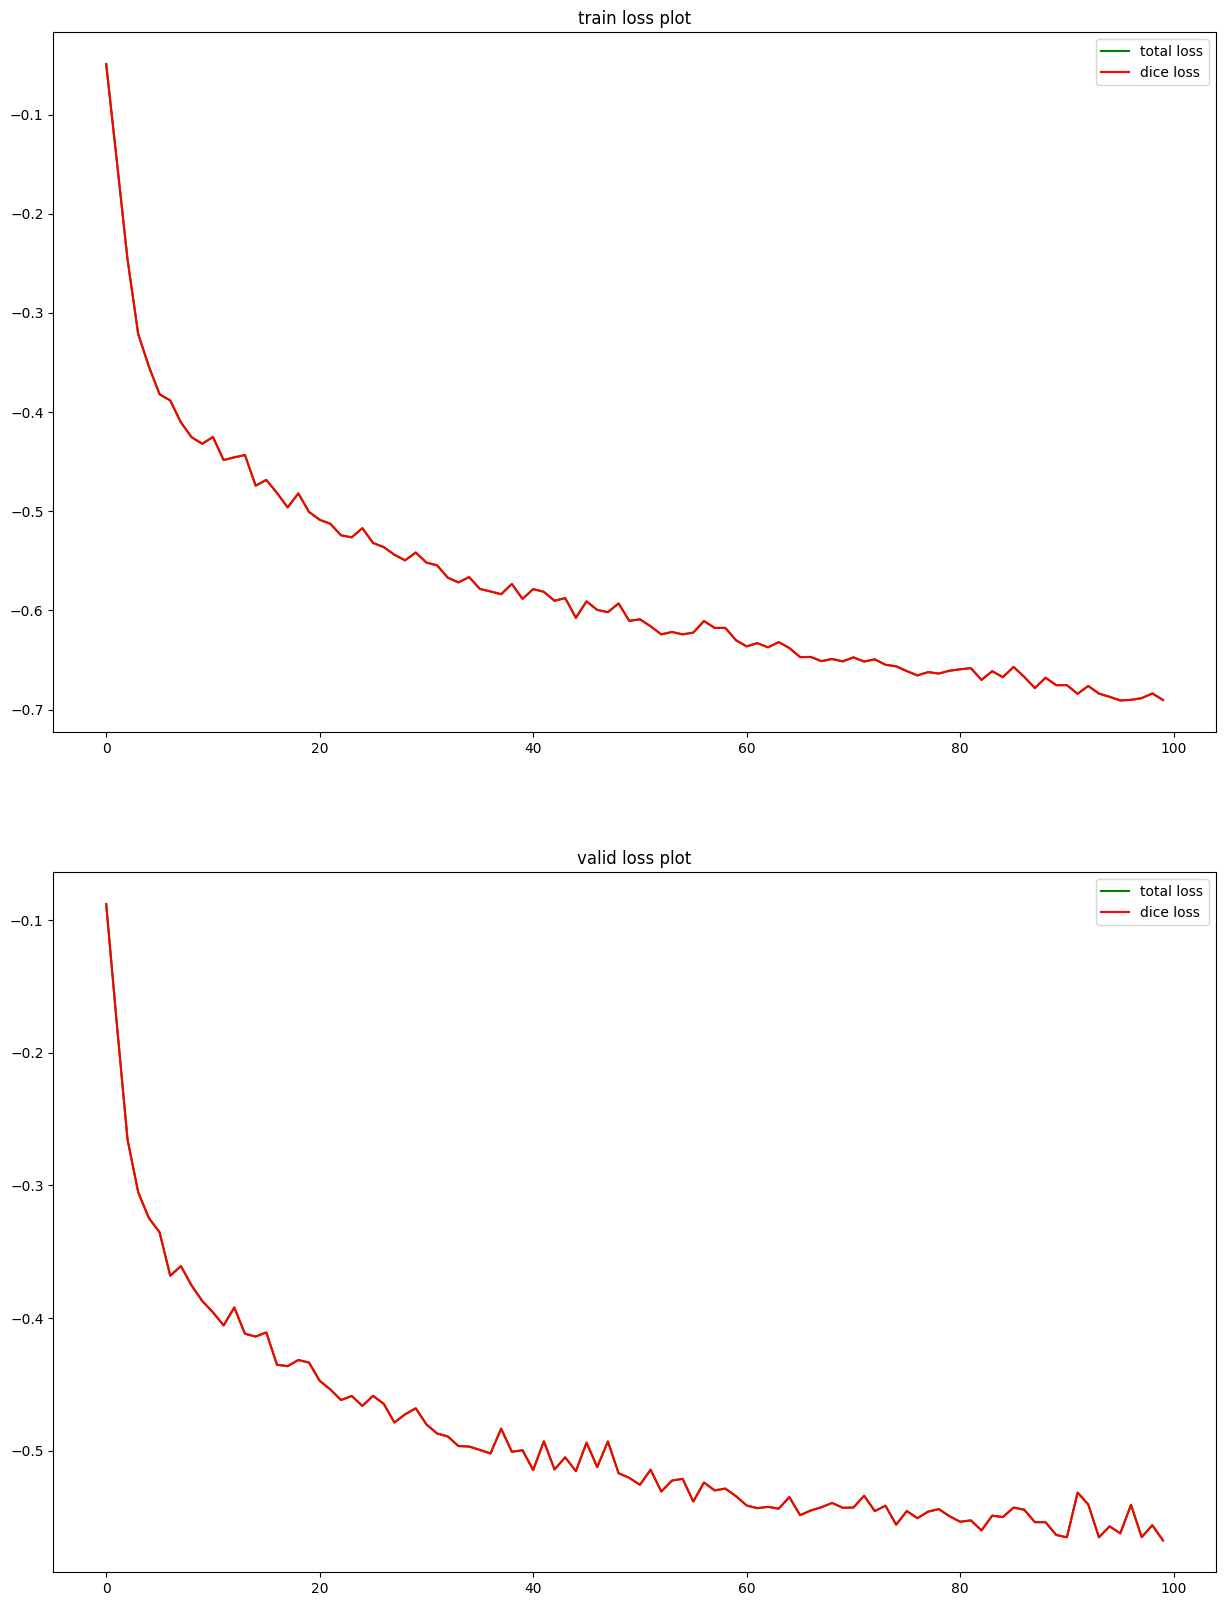

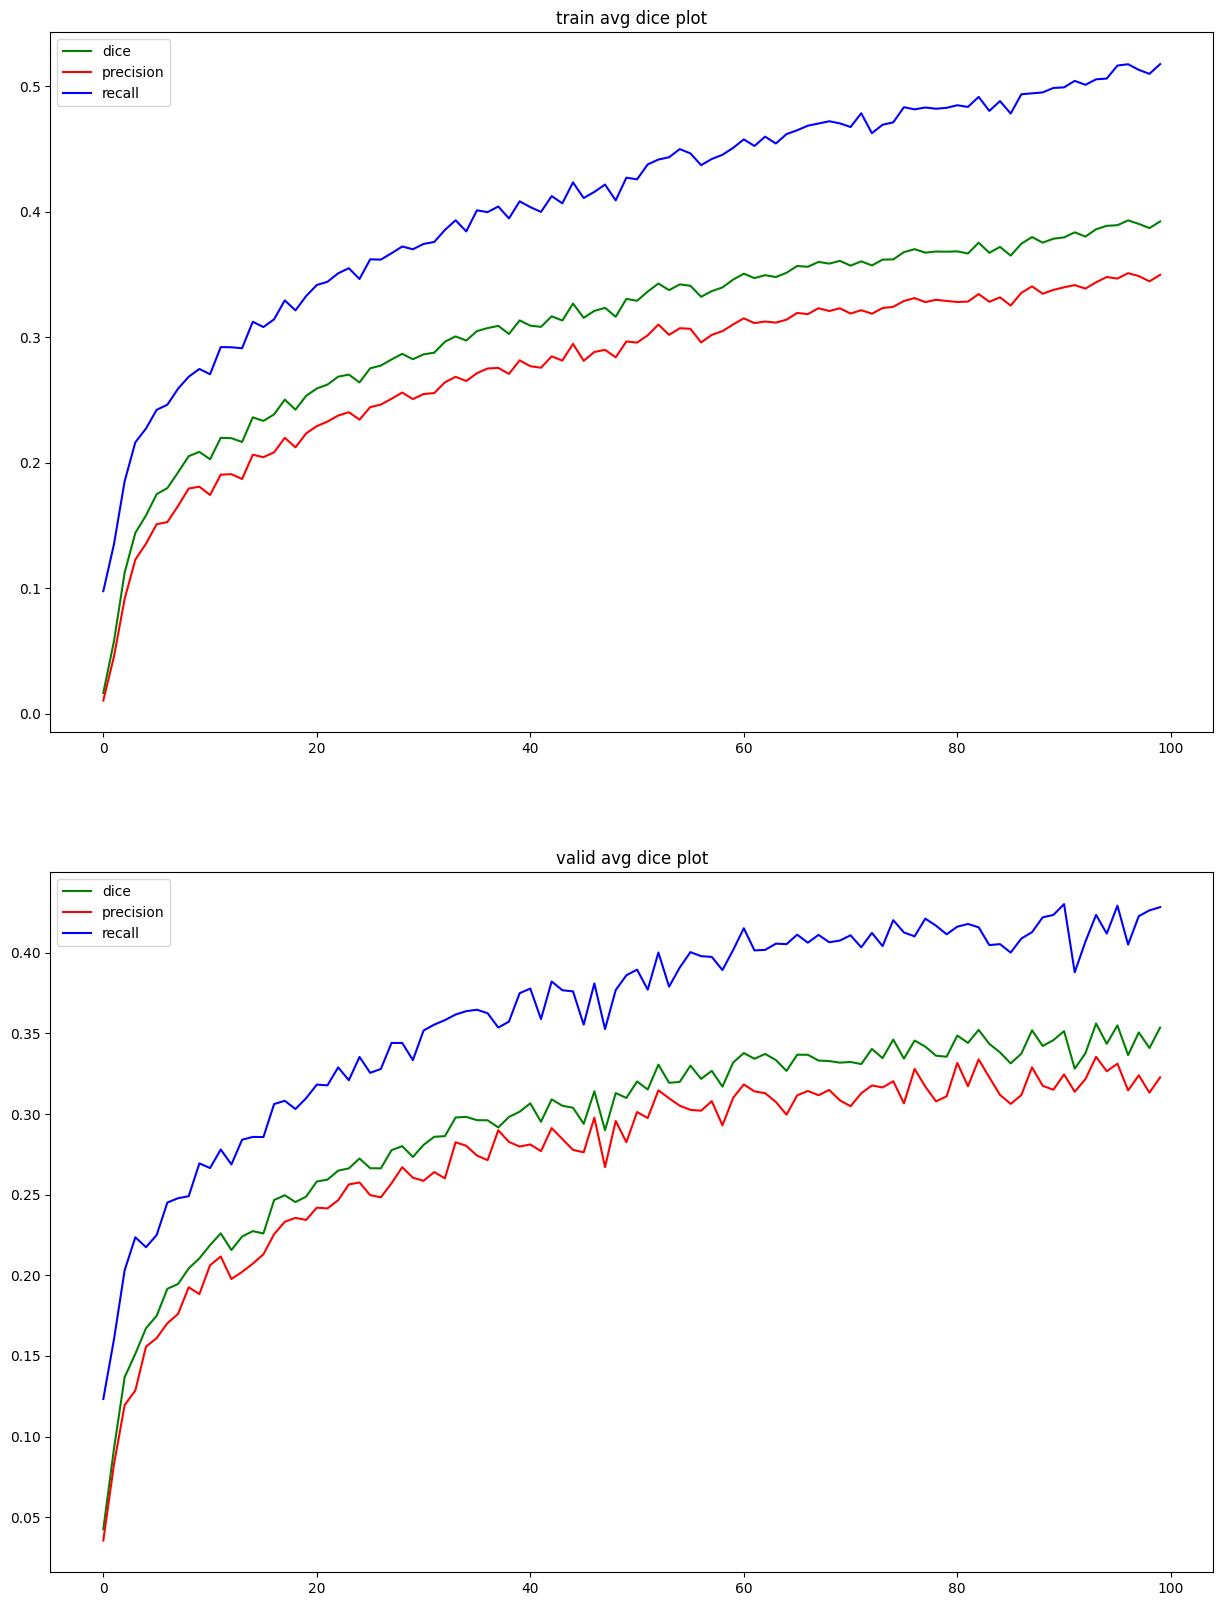

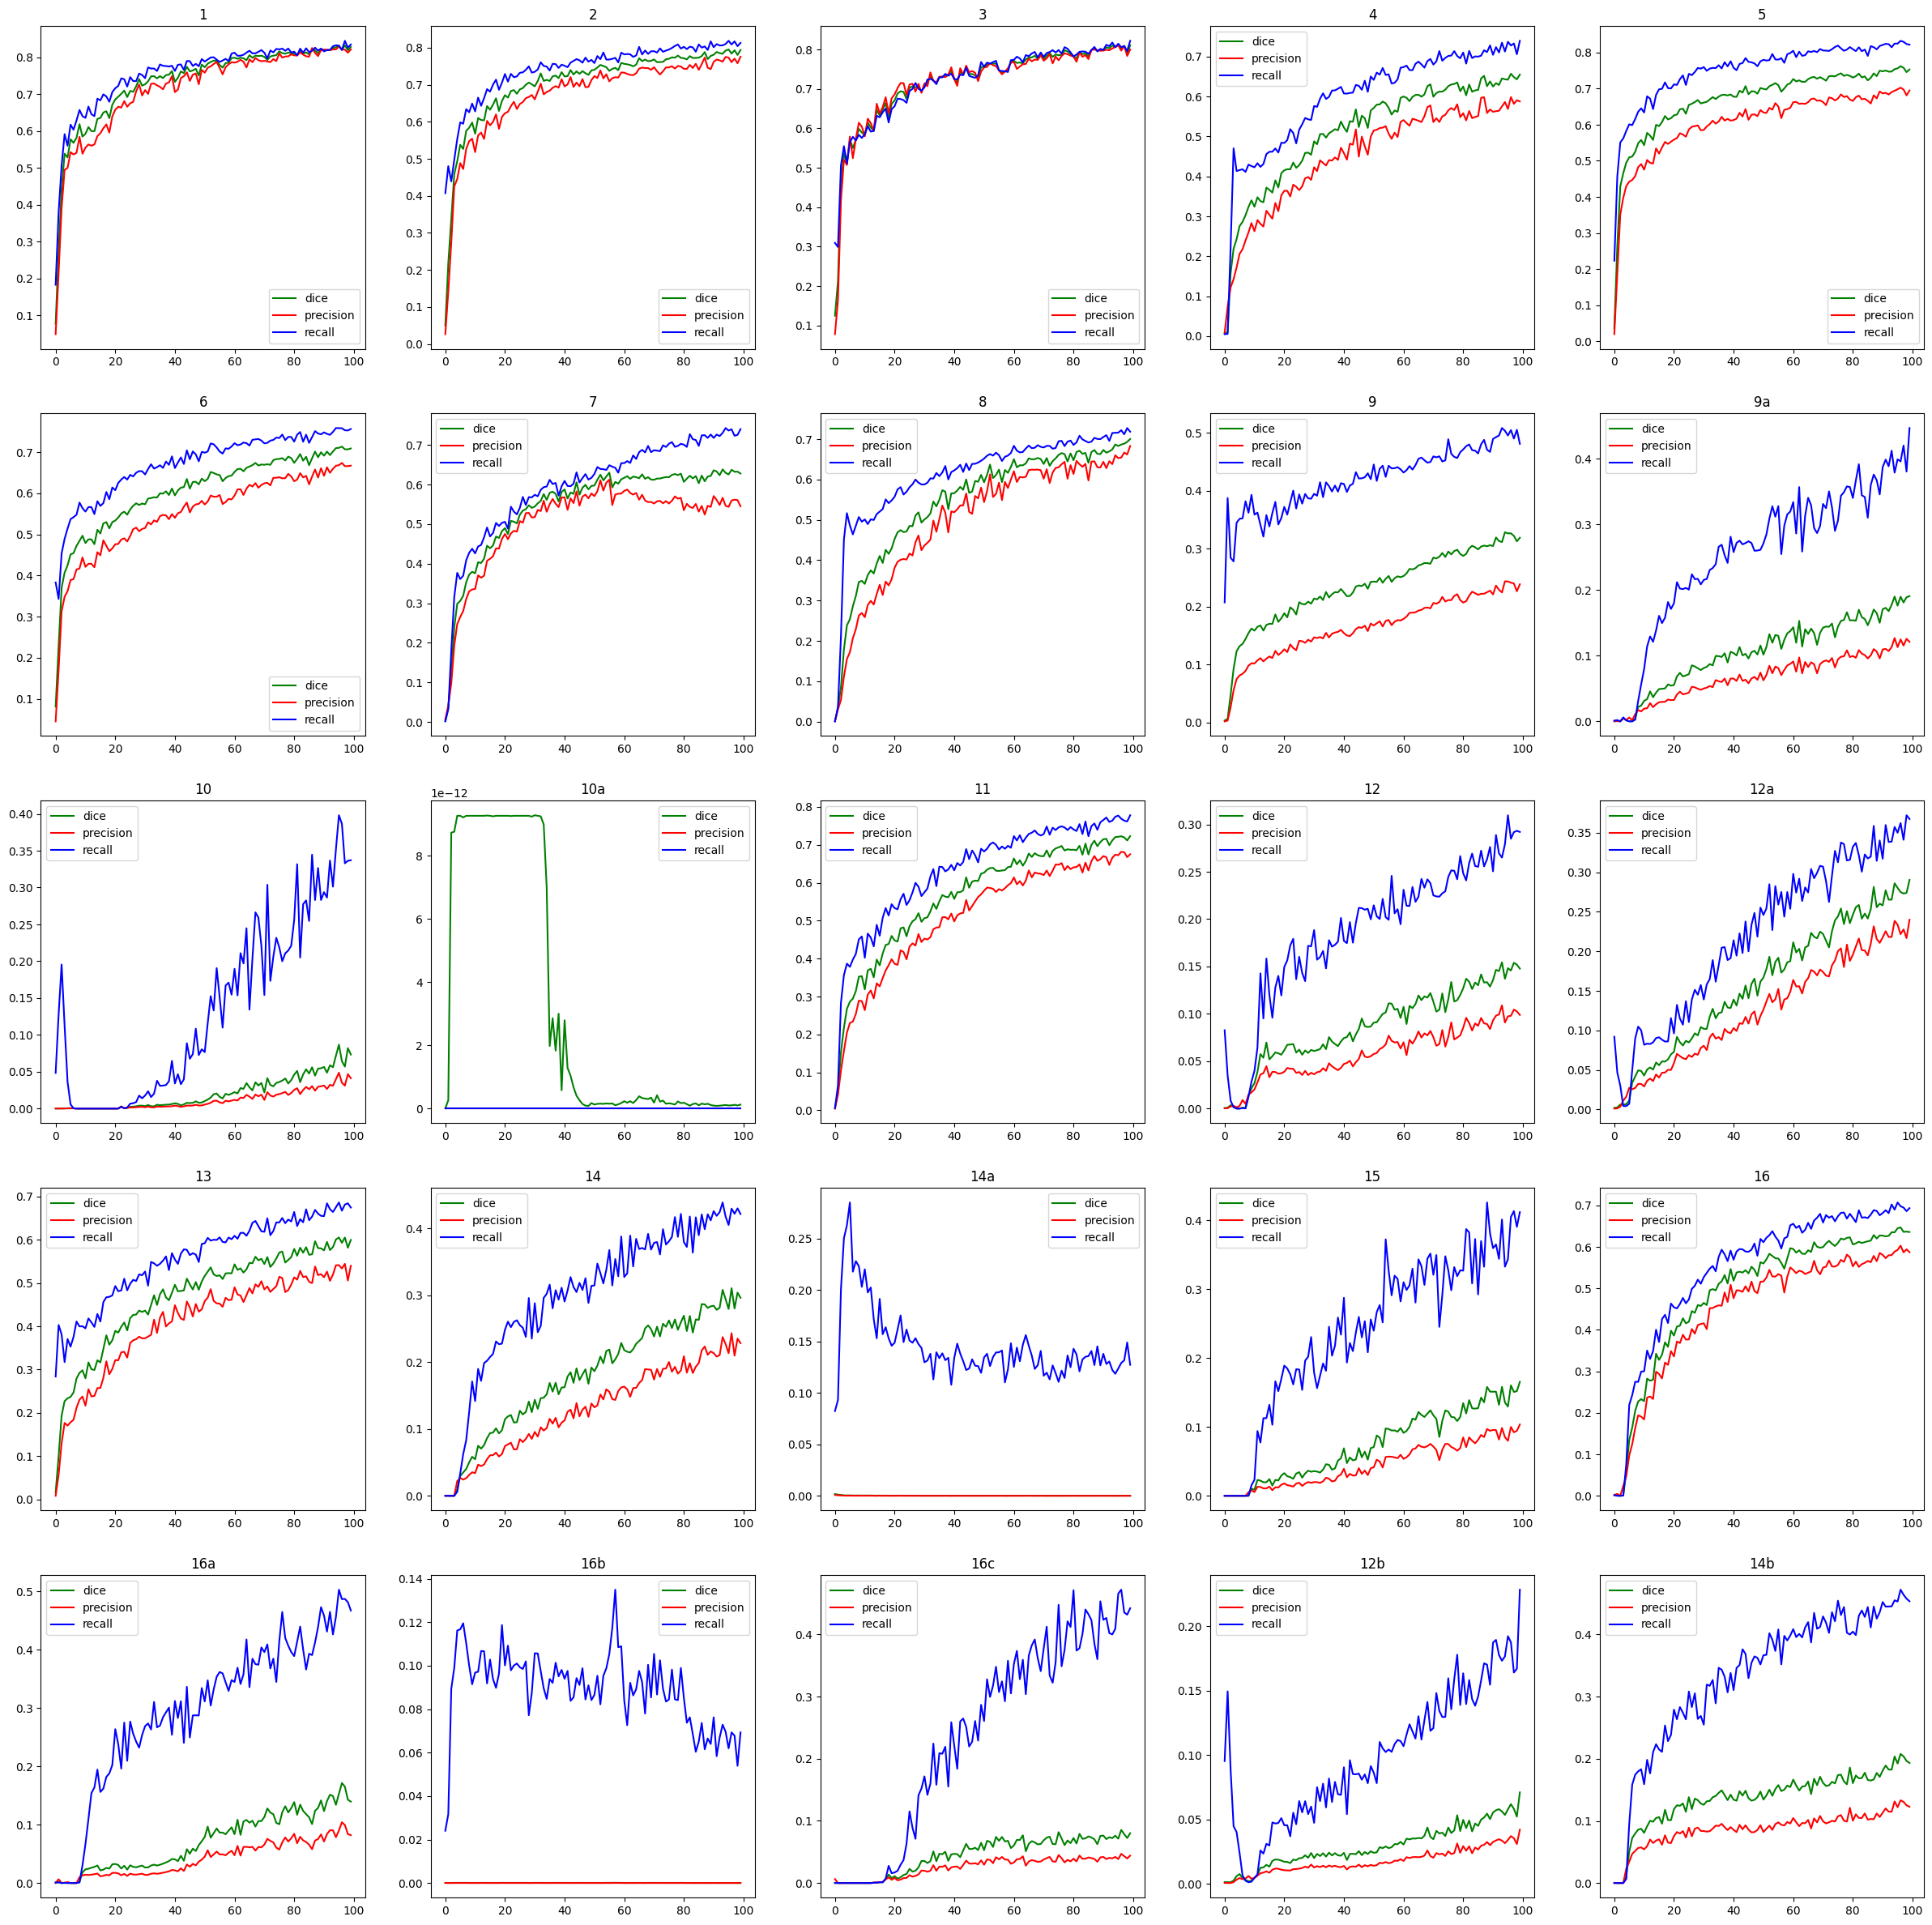

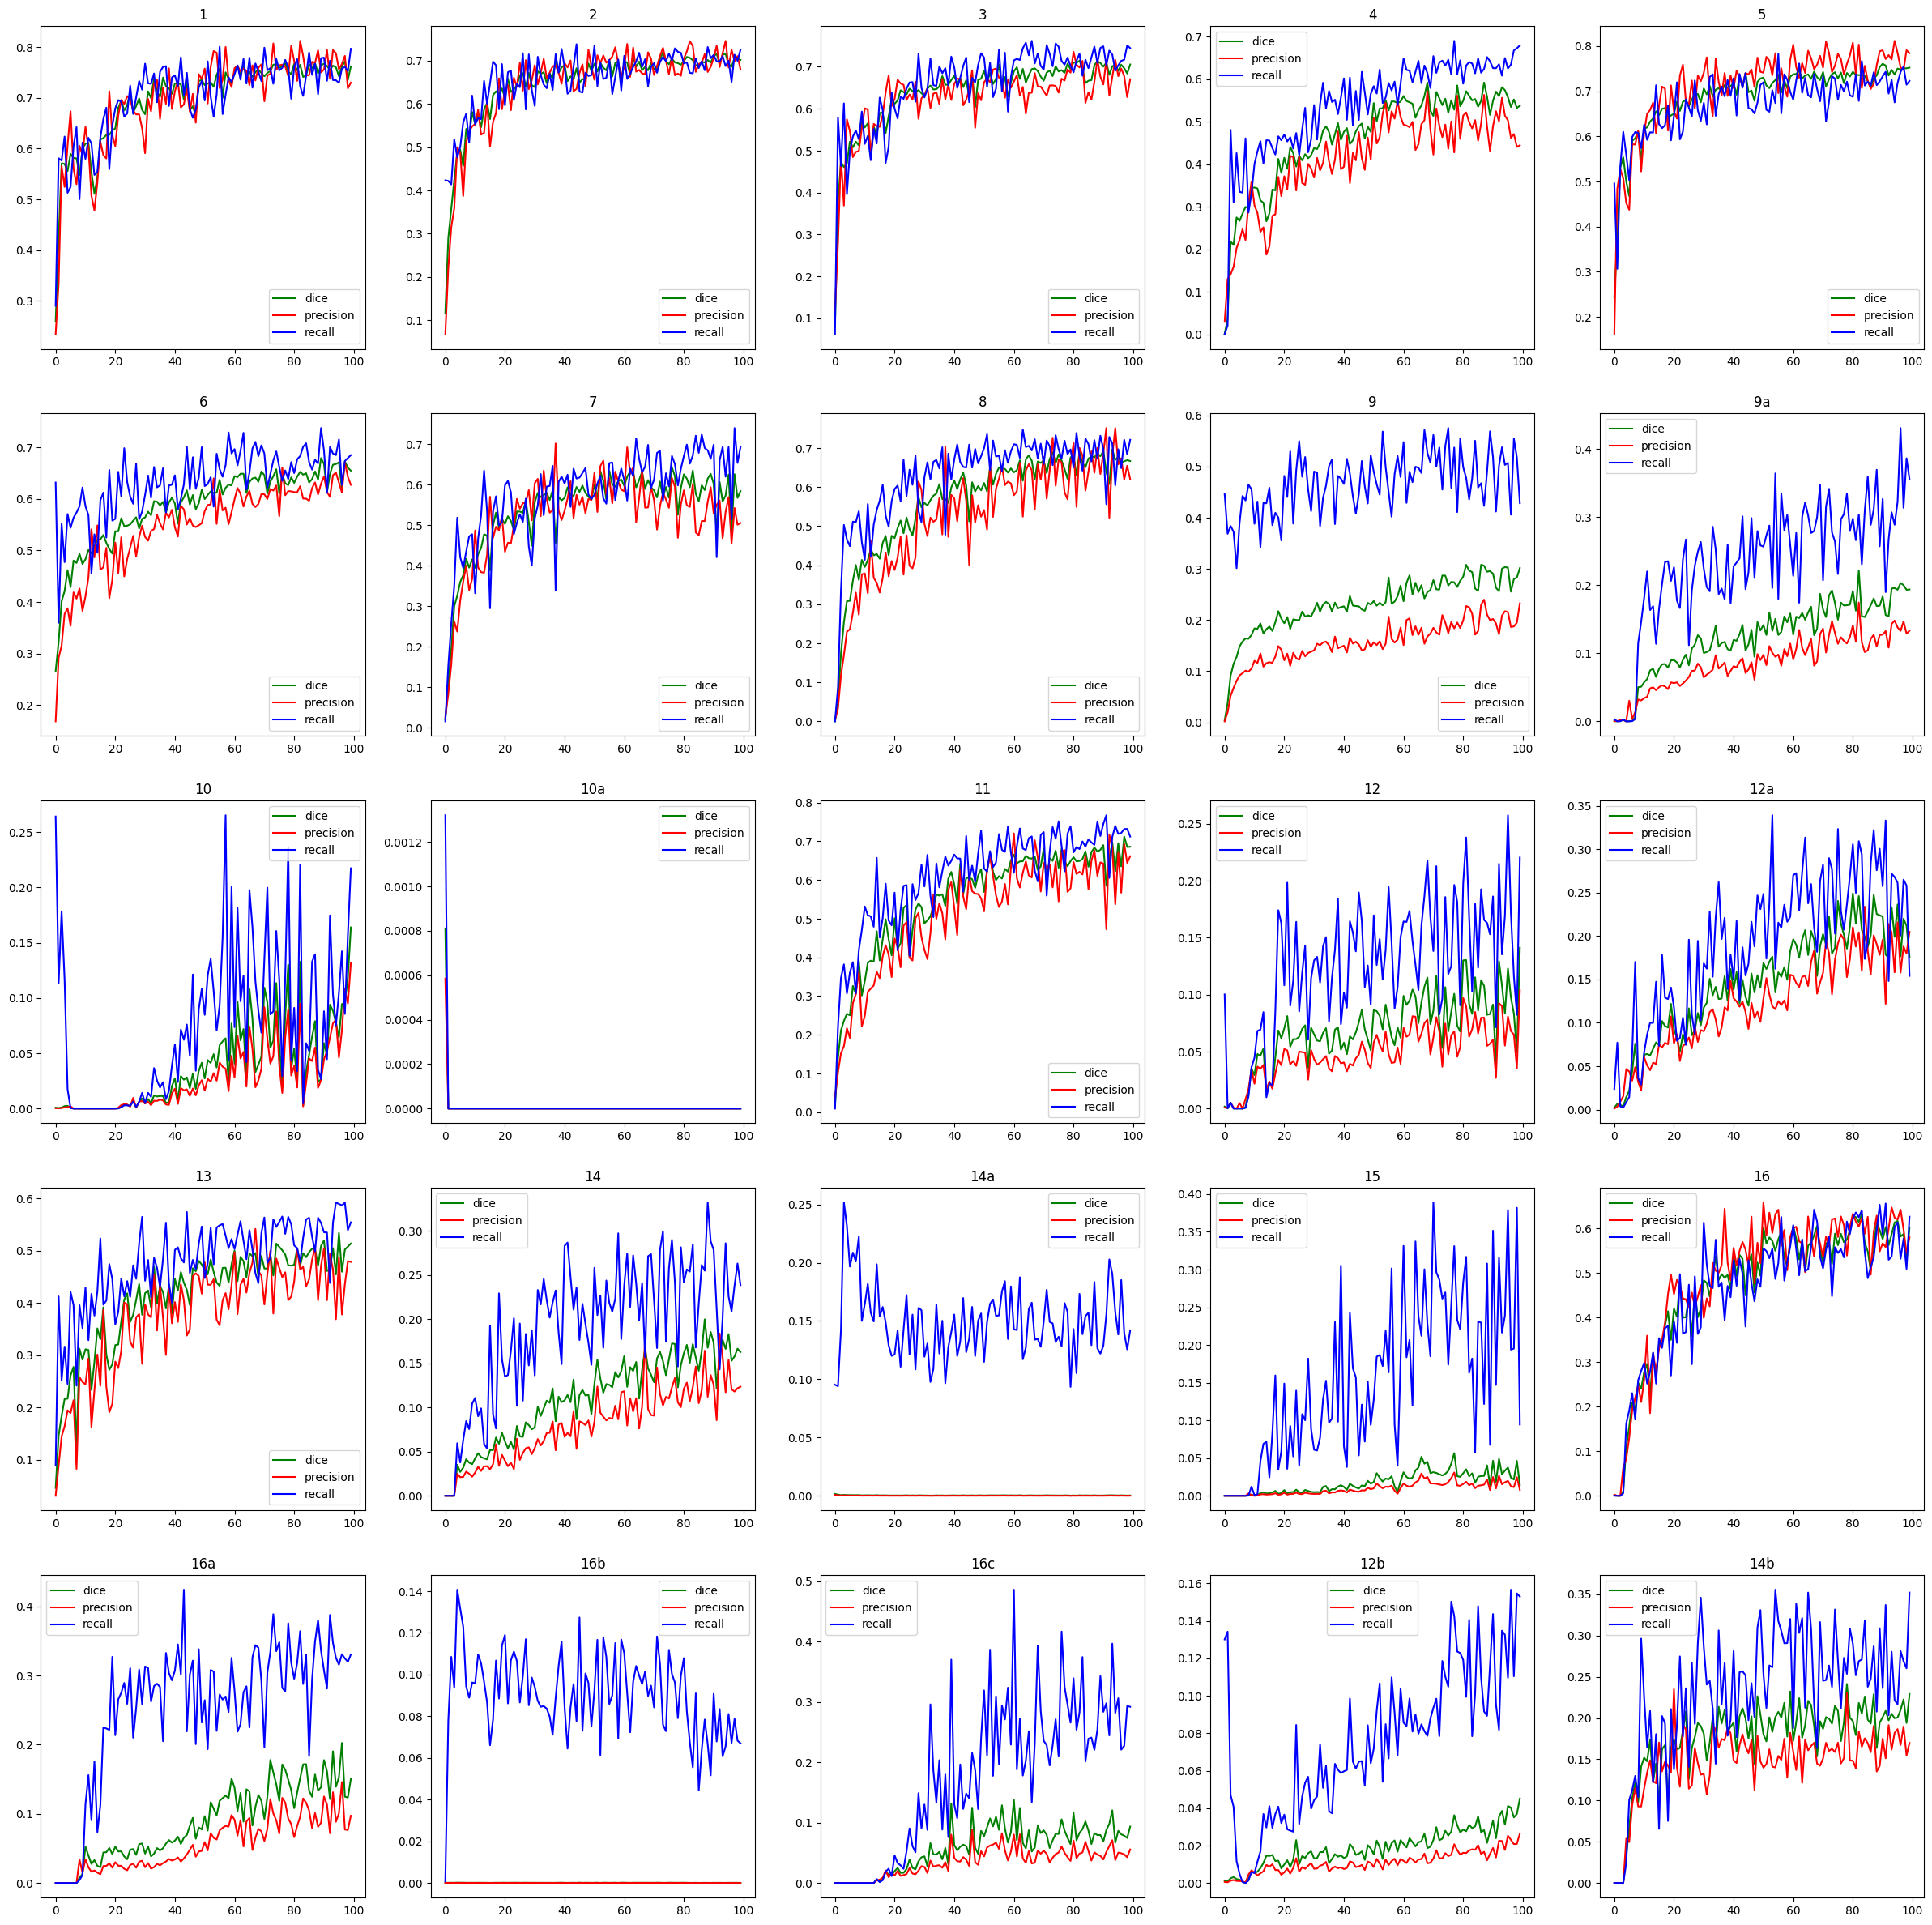

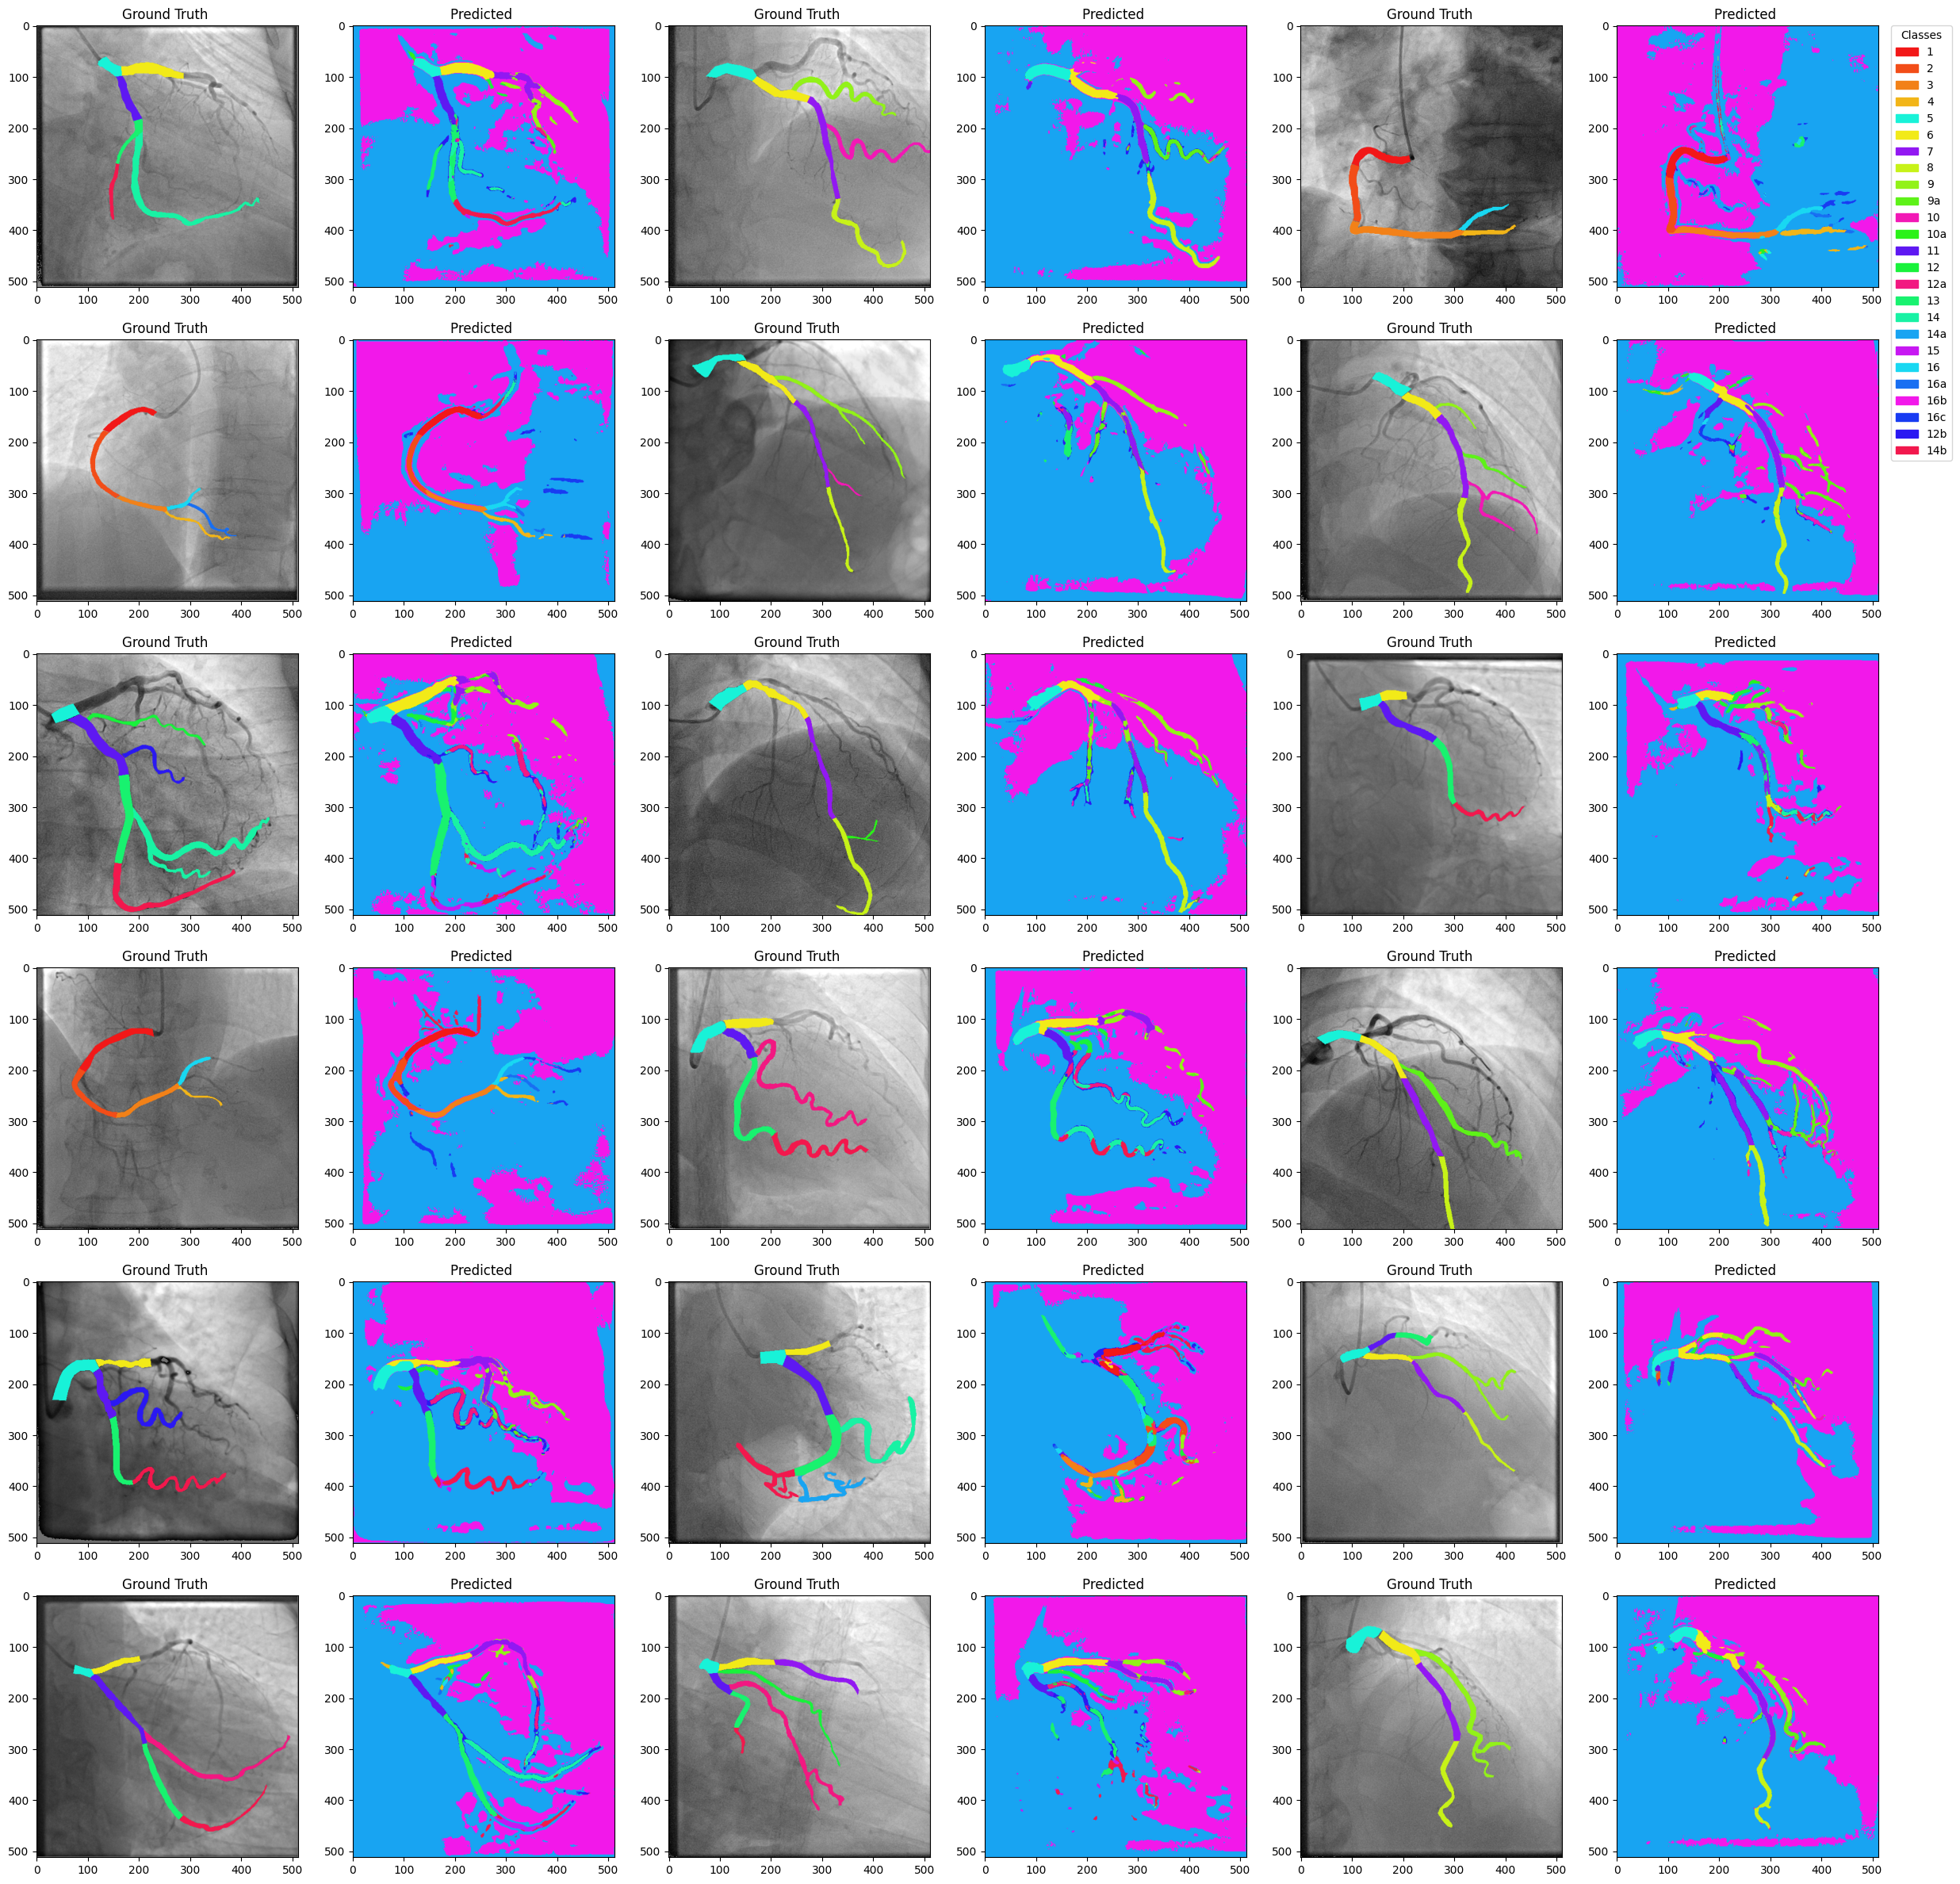

In [10]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)